## Modélisation

Après avoir procéder à l'EDA et à la création de nos jeux de données train et test, nous pouvons passer à l'étape de modélisation.

Notre but ici est donc de prévoir la probabilité de défaut d'un emprunteur et d'aider à prendre la décision de lui accorder un crédit ou non. Notre problématique comprend par ailleurs quelques spécificités :
* La distribution de la variable cible est très déséquilibrée, 92% des emprunteurs du jeu d'entrainement n'ayant pas de difficultés à rembourser leur prêt, contre 8% seulement en ayant. C'est pourtant sur la prédiction des cas positifs, des personnes qui auront du mal à rembourser leur prêt, que nous devons être performant;
* Le coût d'un faux négatif : prédire qu'une personne n'aura pas de difficultés alors qu'elle fera défaut est ici beaucoup plus impactant que de prédire qu'une personne fera défaut alors que non (faux positif ici).

Nous devrons nous adapter à ces différents éléments, par des techniques de rééquilibrage de la cible et par la création d'une fonction de coût qui prenne en compte les particuliarité de notre problème.

Nous allons commencer néanmoins par entraîner des modèles sans prise en compte de ces éléments, cela nous servira de baseline pour la suite.

In [8]:
# Import des packages nécessaires :

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import time
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, make_scorer, classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from datetime import datetime
import lightgbm as lgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import re
from collections import Counter
import pickle

# MLFlow :
from mlflow import MlflowClient
from pprint import pprint
import mlflow
from mlflow.models import infer_signature

# hyperopt :
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from hyperopt.pyll import scope

In [2]:
import warnings
warnings.filterwarnings("ignore")

### Import du jeu de données

In [3]:
# import des données

path = "F:/Utilisateur/Documents/Openclassrooms/Data Scientist/Formation/Projet 7 - Implémentez un modèle de scoring/Code_new/"
train_path = "training.csv"

train_df = pd.read_csv(path + train_path)
print(train_df.shape)
train_df.head()

(307505, 287)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,PREV_CASH_LOAN_PURPOSE_Money for a third person,PREV_CASH_LOAN_PURPOSE_Other,PREV_CASH_LOAN_PURPOSE_Payments on other loans,PREV_CASH_LOAN_PURPOSE_Purchase of electronic equipment,PREV_CASH_LOAN_PURPOSE_Refusal to name the goal,PREV_CASH_LOAN_PURPOSE_Repairs,PREV_CASH_LOAN_PURPOSE_Urgent needs,PREV_CASH_LOAN_PURPOSE_Wedding / gift / holiday,PREV_CASH_LOAN_PURPOSE_XAP,TARGET
0,100002,0,1,0,1,0,202500.0,406597.5,24700.5,351000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
1,100003,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0
2,100004,1,1,1,1,0,67500.0,135000.0,6750.0,135000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
3,100006,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0
4,100007,0,1,0,1,0,121500.0,513000.0,21865.5,513000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0


In [4]:
train_df.drop(['SK_ID_CURR'], axis = 1, inplace=True) # l'ID client n'est pas une variable du modèle

### Fonctions

In [5]:
def create_roc_auc_plot(y_true, y_pred_proba, model_name, save=True):
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    # plot the roc curve for the model
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label=model_name)
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    if save:
        # Save plot
        plt.savefig(f"{model_name}_roc_curve")
    # show the plot
    plt.show()

In [6]:
def create_confusion_matrix_plot(y_true, y_pred, model_name, save=True):
    # Calculer la matrice de confusion
    cm = confusion_matrix(y_true, y_pred)

    # Créer un heatmap à partir de la matrice de confusion
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['Classe 0', 'Classe 1'], 
            yticklabels=['Classe 0', 'Classe 1'])
    plt.title('Matrice de Confusion')
    plt.xlabel('Valeurs Prédites')
    plt.ylabel('Valeurs Réelles')
    if save:
        # Save plot
        plt.savefig(f"{model_name}_confusion_matrix")
    plt.show()

In [7]:
def cost_confusion_matrix_plot(y_true, y_pred, model_name, save=True):
    # Calcul de la matrice de confusion :
    cm = confusion_matrix(y_true, y_pred)
    # On récupère chaque élément de la matrice :
    tn, fp, fn, tp = cm.flatten()
    # On calcule le coût (métier estimé) des erreurs :
    total_cost = fp + (10*fn)
    fn_cost = 10 * fn
    fp_cost = fp
    # Création de la matrice des coûts :
    cost_matrix = [[tn*0, fp_cost],
                   [fn_cost, tp*0]]
    # Visualisation :
    plt.figure(figsize=(8, 6))
    sns.heatmap(cost_matrix, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['Classe 0', 'Classe 1'], 
            yticklabels=['Classe 0', 'Classe 1'])
    plt.title(f'Matrice des coûts - {model_name} : Coût total: {total_cost}')
    plt.xlabel('Valeurs Prédites')
    plt.ylabel('Valeurs Réelles')
    if save:
        # Save plot
        plt.savefig(f"{model_name}_cost_matrix")
    plt.show()
    return total_cost

In [8]:
def custom_cost(y_true, y_pred):
    # On récupère chaque élément de la matrice de confusion :
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).flatten()
    # Pénalisation des faux négatifs 10 fois plus que les faux positifs
    cost = 10 * fn + fp
    return cost

In [9]:
def std_custom_score(y_true, y_pred):
    # Coût total maximal possible
    max_cost = 10 * sum(y_true == 1) + sum(y_true == 0)
    
    # Coût standardisé entre 0 et 1
    std_cost = 1 - custom_cost(y_true, y_pred) / max_cost
    return std_cost

In [10]:
def custom_fbeta(y_true, y_pred):
    # On récupère chaque élément de la matrice de confusion :
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).flatten()
    # Pour beta=3 (on privilégie le recall à la précision) :
    score = (1 + 9*tp) / ((1 + 9*tp) + fp + 9*fn)
    return score

In [11]:
# Création de différents scores pour les optimisations de modèles :

custom_cost_score = make_scorer(custom_cost, greater_is_better=False)
std_custom_cost_score = make_scorer(std_custom_score)
custom_fbeta_score = make_scorer(custom_fbeta)

In [12]:
# Fonction qui transforme une probabilité prédite en classe :
def to_labels(pos_probs, threshold):
 return (pos_probs >= threshold).astype('int')

In [13]:
# Fonction qui trouve et renvoi le meilleur seuil en terme de roc_auc_score :
def best_threshold_func(y_pred_proba, y):
    # keep probabilities for the positive outcome only
    probs = y_pred_proba[:, 1]
    # define thresholds
    thresholds = np.arange(0, 1, 0.001)
    # evaluate each threshold
    scores = [roc_auc_score(y, to_labels(probs, t)) for t in thresholds]
    # get best threshold
    ix = np.argmax(scores)
    best_threshold = thresholds[ix]
    print(f'Threshold={round(best_threshold, 4)}, Score={round(scores[ix], 4)}')
    return best_threshold

In [14]:
# Fonction qui trouve et renvoi le meilleur seuil en fonction de notre score personnalisé :
def best_threshold_func_custom(y_pred_proba, y):
    # keep probabilities for the positive outcome only
    probs = y_pred_proba[:, 1]
    # define thresholds
    thresholds = np.arange(0, 1, 0.001)
    # evaluate each threshold
    scores = [std_custom_score(y, to_labels(probs, t)) for t in thresholds]
    # get best threshold
    ix = np.argmax(scores)
    best_threshold = thresholds[ix]
    print(f'Threshold={round(best_threshold, 4)}, Score={round(scores[ix], 4)}')
    return best_threshold

In [15]:
# Fonction applique une calibration sur un modèle via CalibratedClassifierCV et méthode isotonic :

def calibration(model, X, y):
    # Calibration des modèles non linéaires :
    calibrated_clf = CalibratedClassifierCV(model, method='isotonic', cv=3)
    calibrated_clf.fit(X, y)
    return calibrated_clf

In [16]:
# Définition d'une fonction d'entraînement des modèles :

def training_model(clf_model, X_train, y_train, threshold_score='custom'):

    # training model :
    clf_model.fit(X_train, y_train)
    prob_predictions = clf_model.predict_proba(X_train)

    # Calcul du meilleur seuil en fonction du score choisi :
    if threshold_score == 'roc_auc':
        best_threshold = best_threshold_func(prob_predictions, y_train)
        predictions = to_labels(prob_predictions[:, 1], best_threshold)
    elif threshold_score == 'custom':
        best_threshold = best_threshold_func_custom(prob_predictions, y_train)
        predictions = to_labels(prob_predictions[:, 1], best_threshold)

    # Some metrics :
    train_acc = accuracy_score(y_train, predictions)
    train_prec = precision_score(y_train, predictions)
    train_recall = recall_score(y_train, predictions)
    train_f1_score = f1_score(y_train, predictions)
    train_custom_fbeta = custom_fbeta(y_train, predictions)
    train_roc_auc = roc_auc_score(y_train, predictions)
    train_custom_cost = custom_cost(y_train, predictions)
    train_custom_score = std_custom_score(y_train, predictions)

    # log metrics in mlflow :
    mlflow.log_metric("train_accuracy", train_acc)
    mlflow.log_metric("train_precision", train_prec)
    mlflow.log_metric("train_recall", train_recall)
    mlflow.log_metric("train_f1_score", train_f1_score)
    mlflow.log_metric("train_custom_fbeta", train_custom_fbeta)
    mlflow.log_metric("train_roc_auc", train_roc_auc)
    mlflow.log_metric("train_custom_cost", train_custom_cost)
    mlflow.log_metric("train_custom_score", train_custom_score)

    # print results :
    print(f"train_accuracy: {train_acc:.3f}")
    print(f"train_precision: {train_prec:.3f}")
    print(f"train_recall: {train_recall:.3f}")
    print(f"train_f1_score: {train_f1_score:.3f}")
    print(f"train_custom_fbeta: {train_custom_fbeta:.3f}")
    print(f"train_roc_auc: {train_roc_auc:.3f}")
    print(f"train_custom_cost: {train_custom_cost:.3f}")
    print(f"train_custom_score: {train_custom_score:.3f}")

In [17]:
# Définition d'une fonction d'évaluation des modèles :

def evaluate_model(clf_model, X_train, y_train, X_val, y_val, model_name, threshold_score='custom'):

    # training model :
    start_time = time.time()
    clf_model = clf_model.fit(X_train, y_train)
    training_time = round(time.time() - start_time, 4)
    prob_predictions = clf_model.predict_proba(X_val)

    # Calcul du meilleur seuil en fonction du score choisi :
    if threshold_score == 'roc_auc':
        best_threshold = best_threshold_func(prob_predictions, y_val)
        predictions = to_labels(prob_predictions[:, 1], best_threshold)
    elif threshold_score == 'custom':
        best_threshold = best_threshold_func_custom(prob_predictions, y_val)
        predictions = to_labels(prob_predictions[:, 1], best_threshold)
    
    # Some metrics :
    eval_acc = accuracy_score(y_val, predictions)
    eval_prec = precision_score(y_val, predictions)
    eval_recall = recall_score(y_val, predictions)
    eval_f1_score = f1_score(y_val, predictions,)
    eval_custom_fbeta = custom_fbeta(y_val, predictions)
    eval_roc_auc = roc_auc_score(y_val, predictions)
    eval_custom_cost = custom_cost(y_val, predictions)
    eval_custom_score = std_custom_score(y_val, predictions)

    # log metrics in mlflow :
    mlflow.log_metric("eval_accuracy", eval_acc)
    mlflow.log_metric("eval_precision", eval_prec)
    mlflow.log_metric("eval_recall", eval_recall)
    mlflow.log_metric("eval_f1_score", eval_f1_score)
    mlflow.log_metric("eval_custom_fbeta", eval_custom_fbeta)
    mlflow.log_metric("eval_roc_auc", eval_roc_auc)
    mlflow.log_metric("eval_custom_cost", eval_custom_cost)
    mlflow.log_metric("eval_custom_score", eval_custom_score)
    mlflow.log_metric("training_time", training_time)

    # print results :
    print(f"eval_accuracy: {eval_acc:.3f}")
    print(f"eval_precision: {eval_prec:.3f}")
    print(f"eval_recall: {eval_recall:.3f}")
    print(f"eval_f1_score: {eval_f1_score:.3f}")
    print(f"eval_custom_fbeta: {eval_custom_fbeta:.3f}")
    print(f"eval_roc_auc: {eval_roc_auc:.3f}")
    print(f"eval_custom_cost: {eval_custom_cost:.3f}")
    print(f"eval_custom_score: {eval_custom_score:.3f}")
    print(f"training_time: {training_time}")

    # ROC Curve :
    y_pred_proba = clf_model.predict_proba(X_val)[:,1]
    create_roc_auc_plot(y_val, y_pred_proba, model_name)

    # Confusion Matrix :
    create_confusion_matrix_plot(y_val, predictions, model_name)

    # Cost Matrix :
    cost_confusion_matrix_plot(y_val, predictions, model_name)

    # Log ROC Curve and Confusion Matrix :
    mlflow.log_artifact(f"{model_name}_confusion_matrix.png")
    mlflow.log_artifact(f"{model_name}_roc_curve.png")
    mlflow.log_artifact(f"{model_name}_cost_matrix.png")

    dict_metrics = {
        'eval_acc' : accuracy_score(y_val, predictions),
        'eval_prec' : precision_score(y_val, predictions),
        'eval_recall' : recall_score(y_val, predictions),
        'eval_f1_score' : f1_score(y_val, predictions,),
        'eval_custom_fbeta' : custom_fbeta(y_val, predictions),
        'eval_roc_auc' : roc_auc_score(y_val, predictions),
        'eval_custom_cost' : custom_cost(y_val, predictions),
        'eval_custom_score' : std_custom_score(y_val, predictions),
        'training_time': training_time
    }
    
    return clf_model, dict_metrics

### Préparation des données

In [5]:
# Séparation du jeu de données, 3 jeux de données car on sera amené à utiliser de la calibration :

X = train_df.drop(['TARGET'], axis=1)
y = train_df['TARGET']

# On doit changer le nom des colonnes car LightLGBM ne supporte pas certains caractères :
new_names = {col: re.sub(r'[^A-Za-z0-9_]+', '', col) for col in X.columns}
new_n_list = list(new_names.values())
# [LightGBM] Feature appears more than one time.
new_names = {col: f'{new_col}_{i}' if new_col in new_n_list[:i] else new_col for i, (col, new_col) in enumerate(new_names.items())}
X = X.rename(columns=new_names)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=65)
print(f"train_dimension : {X_train.shape}, val_dimension : {X_val.shape}.")

train_dimension : (215253, 285), val_dimension : (92252, 285).


On vérifie la distribution de la target dans les deux jeux de données :

In [19]:
# distribution target :
y_train.value_counts(normalize=True)

TARGET
0    0.919773
1    0.080227
Name: proportion, dtype: float64

In [20]:
# distribution target :
y_val.value_counts(normalize=True)

TARGET
0    0.918094
1    0.081906
Name: proportion, dtype: float64

### Modèles de base

#### Entrainement d'une régression logistique, avec paramètres par défaut

In [21]:
# Normalisation des données par application d'un Minmaxscaler :

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val) # On fait attention d'appliquer la transformation entraînée sur le jeu d'entraînement

In [22]:
# On fixe une valeur de random_state et entraîne un modèle :
random_state = 42
lr = LogisticRegression(random_state=random_state)
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_val_scaled)
y_pred_proba = lr.predict_proba(X_val_scaled)[:,1]
print(f"Accuracy : {round(accuracy_score(y_val, y_pred), 4)}")
print(f"ROC_AUC_score : {round(roc_auc_score(y_val, y_pred), 4)}")

Accuracy : 0.9184
ROC_AUC_score : 0.5097


On voit que le modèle prédit de manière quasi systématique la classe dominante.

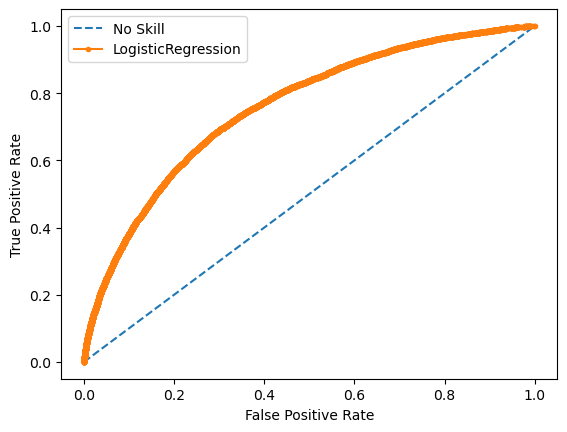

In [23]:
create_roc_auc_plot(y_val, y_pred_proba, "LogisticRegression", save=False)

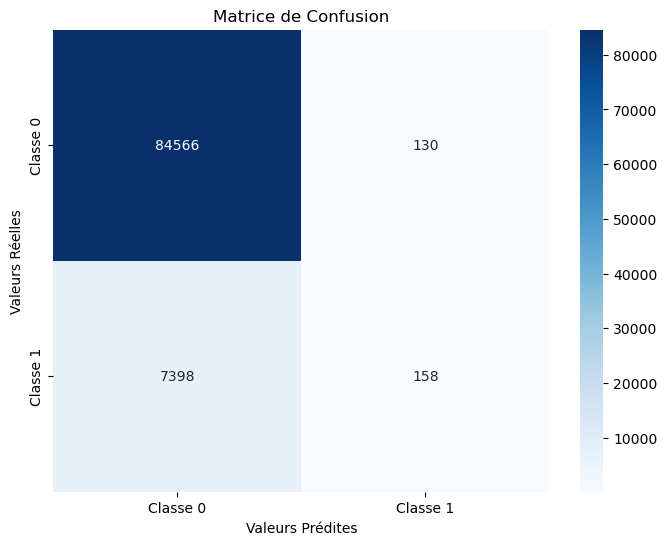

In [24]:
create_confusion_matrix_plot(y_val, y_pred, "LogisticRegression", save=False)

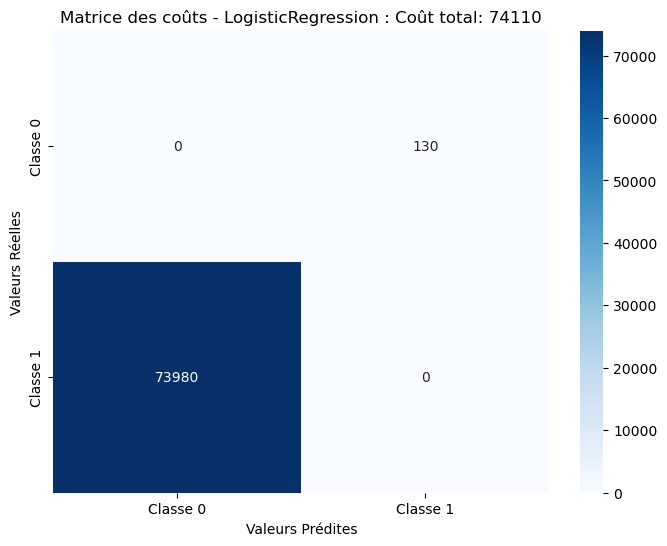

74110

In [25]:
cost_confusion_matrix_plot(y_val, y_pred, "LogisticRegression", save=False)

#### Entrainement d'un RandomForest Classifier avec paramètres par défaut :

In [26]:
rf_clf = RandomForestClassifier(random_state=random_state)
rf_clf.fit(X_train_scaled, y_train)
y_pred = rf_clf.predict(X_val_scaled)
y_pred_proba = rf_clf.predict_proba(X_val_scaled)[:,1]
print(f"Accuracy : {round(accuracy_score(y_val, y_pred), 4)}")
print(f"ROC_AUC_score : {round(roc_auc_score(y_val, y_pred), 4)}")

Accuracy : 0.9181
ROC_AUC_score : 0.5004


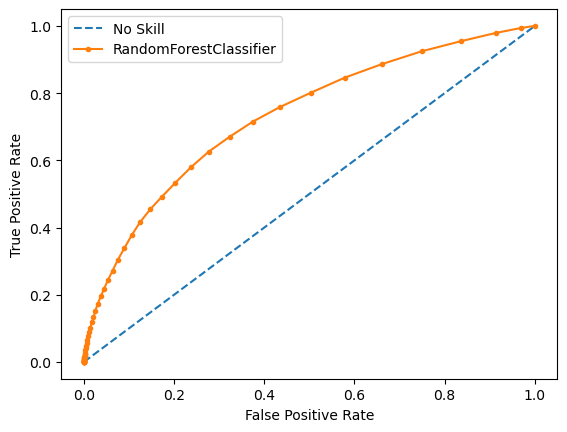

In [27]:
create_roc_auc_plot(y_val, y_pred_proba, "RandomForestClassifier", save=False)

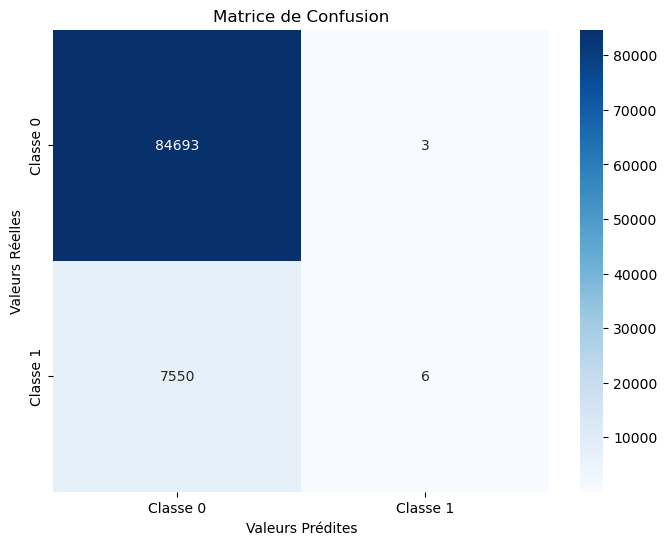

In [28]:
create_confusion_matrix_plot(y_val, y_pred, "RandomForestClassifier", save=False)

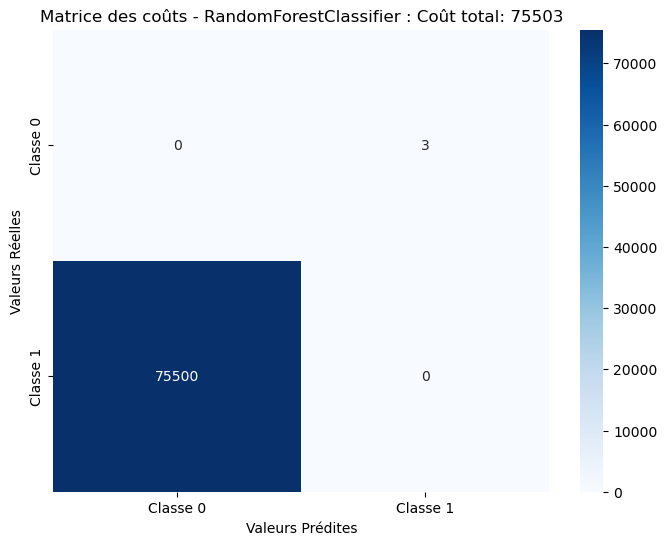

75503

In [29]:
cost_confusion_matrix_plot(y_val, y_pred, "RandomForestClassifier", save=False)

C'est encore plus flagrant avec ce modèle.

### Comparaison de différents modèles

Le déséquilibre des classes étaient l'une des particularité de notre problématique. L'autre étant le coût bien plus important des faux négatifs comparés aux faux positifs. Pour prendre cela en compte, nous allons créer une fonction de coût qui pénalise plus fortement ces faux négatifs. Nous pouvons prendre comme hypothèse (à affiner par un expert métier) qu'un faux négatif est 10 fois plus coûteux qu'un faux positif.

#### Prise en compte du déséquilibre des classes

* certains modèles ont un (ou des) hyperparamètres comme 'class_weight' permettant de pénaliser plus fortement les erreurs faites sur la classe minoritaire.

* Techniques de resampling :

- Il existe plusieurs méthodes de rééchantillonage qui permettent d'équilibrer la distribution des classes au sein d'un jeu de données, soit en augmentant le nombre d'observations appartenant à la classe minoritaire (oversampling), soit en réduisant le nombre d'observations appartenant à la classe majoritaire (undersampling).

- l'undersampling a l'avantage de réduire la taille du jeu de données et donc de réduire le temps d'entraînement des modèles. Cependant il fait perdre de l'information puisqu'on supprime des données. Certaines méthodes permettent de ne supprimer que les observations qui sont en réalité assez proches d'observations appartenant à la classe minoritaire, de façon à augmenter la distinction entre les classes et à "faciliter" la tâche de classification par les modèles.

- l'oversampling a l'avantage de ne pas faire perdre d'information. Il existe là aussi plusieurs façons de mettre en place cette méthode, l'une d'entre elles, SMOTE, est celle que nous utiliserons. Elle fonctionne de la manière suivante : sélection d'un individu de la classe minoritaire -> choix aléatoire d'un des plus proches voisins de cet individu -> création synthétique d'observations situées sur une droite reliant ces 2 points et ayant donc des caractéristiques proches.

Il semble conseiller de mixer les deux approches et d'effectuer à la fois de l'oversampling et de l'undersampling pour obtenir les meilleurs résultats. Il ne s'agit pas d'avoir forcément des classes parfaitement équilibrées.
Par ailleurs, ces transformations sont censées s'appliquer uniquement au jeu de données d'entraînement.

#### Détermination du seuil de probabilité :

* Nous changeons également le seuil de probabilité à partir duquel un modèle va prédire qu'une observation appartient à la classe 0 ou 1. Par défaut ce seuil est fixé à 0.5 : si la probabilité est > 0.5 alors 1 sera prédit, 0 sinon. Nous avons créé deux fonctions 'best_threshold_func' et 'best_threshold_func_cust' afin de trouver le seuil optimal pour notre problématique :

    - best_threshold_func : le seuil optimal maximise le roc_auc_score ;
    - best_threshold_func_cust : le seuil optimal maximise notre score 'métier'.

* Calibration :

- Certains modèles, en particulier les modèles non linéaires, ne prédisent pas réellement des probabilités d'appartenance à une classe mais une approximation de celle-ci. Il existe des méthodes permettant de calibrer ces approximations afin d'avoir une plus grande confiance dans les probabilités prédites.

- Après avoir sélectionné le modèle donnant les meilleurs résultats (après recherche des meilleurs hyperparamètres d'hyperopt), nous verrons si les résultats peuvent être encore amélioré avec un CalibrationCV de scikit-learn.

Nous allons utiliser MLFlow pour réaliser un tracking des différents modèles et pour y enregistrer des métriques, paramètres et le ou les meilleurs modèles.

Dans terminal : 'mlflow ui --backend-store-uri sqlite:///mlflow.db'

In [30]:
# mlflow ui :
mlflow.set_tracking_uri('http://127.0.0.1:5000')

In [31]:
# Création d'une "experience" MLFLow :

mlflow.set_experiment("HomeCredit_Classifier_3_Best_Models")

2024/05/09 09:57:29 INFO mlflow.tracking.fluent: Experiment with name 'HomeCredit_Classifier_3_Best_Models' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/7', creation_time=1715241449923, experiment_id='7', last_update_time=1715241449923, lifecycle_stage='active', name='HomeCredit_Classifier_3_Best_Models', tags={}>

#### Dummy Classifier

In [6]:
# Transformation par MinMaxScaler :
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Application over/under sampling sur jeu d'entraînement :
over_sampler = SMOTE(sampling_strategy=0.1)
under_sampler = RandomUnderSampler(sampling_strategy=0.5)
pipe_samp = imbpipeline(steps = [('over', over_sampler), ('under', under_sampler)])
X_train_samp, y_train_samp = pipe_samp.fit_resample(X_train_scaled, y_train)

In [7]:
# distribution target après le sampling :
y_train_samp.value_counts(normalize=True)

TARGET
0    0.666667
1    0.333333
Name: proportion, dtype: float64

In [33]:
# count # of examples in each class
counter = Counter(y_train_samp)
# estimate scale_pos_weight value, assuming the class labels are 0 and 1. Modify according to your use-case
weight = counter[0] / counter[1]

In [34]:
print(weight)

2.0


In [35]:
# Définition du modèle :
dummy_clf = DummyClassifier(strategy='most_frequent')

In [36]:
experiment = mlflow.get_experiment_by_name("HomeCredit_Classifier_3_Best_Models")

2024/05/09 09:57:32 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



Threshold=0.0, Score=0.8333
train_accuracy: 0.333
train_precision: 0.333
train_recall: 1.000
train_f1_score: 0.500
train_custom_fbeta: 0.818
train_roc_auc: 0.500
train_custom_cost: 39596.000
train_custom_score: 0.833
Threshold=0.001, Score=0.5285
eval_accuracy: 0.918
eval_precision: 0.000
eval_recall: 0.000
eval_f1_score: 0.000
eval_custom_fbeta: 0.000
eval_roc_auc: 0.500
eval_custom_cost: 75560.000
eval_custom_score: 0.529
training_time: 0.001


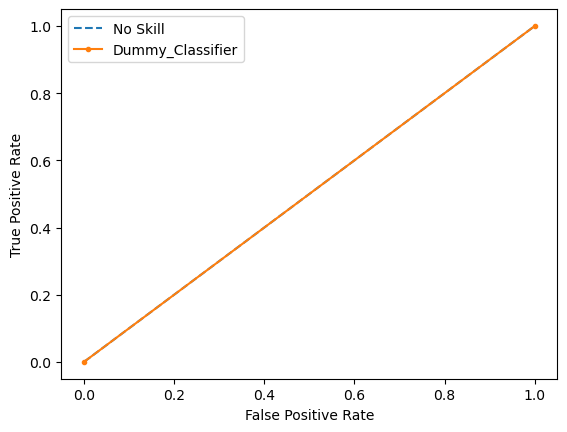

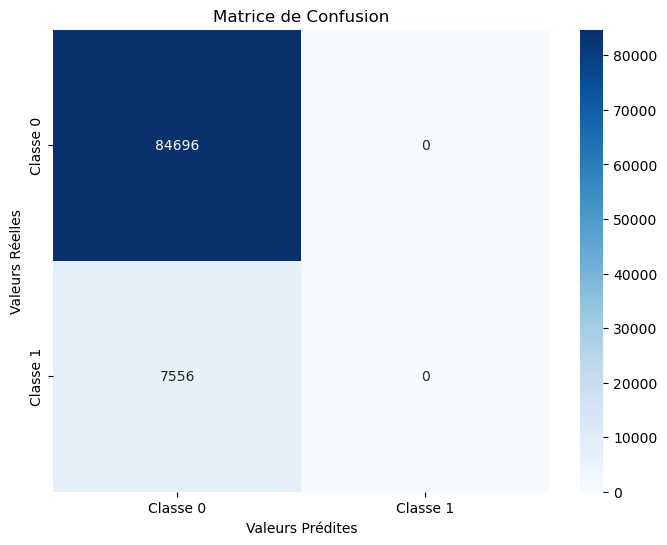

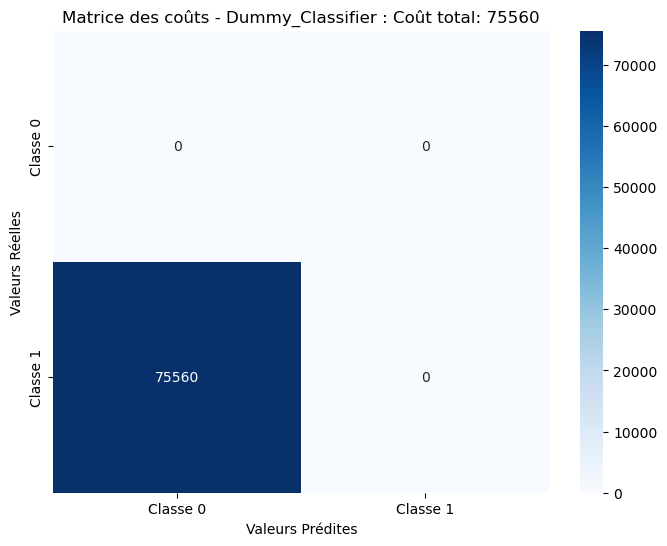

Model run : 2f3a658e3aa24f859fec577ea665d6d2


In [37]:
with mlflow.start_run(experiment_id=experiment.experiment_id, run_name='Dummy Classifier'):
    training_model(dummy_clf, X_train_samp, y_train_samp, threshold_score='custom')
    dummy_classifier, dummy_metrics = evaluate_model(dummy_clf, X_train_samp, y_train_samp, X_val_scaled, y_val, "Dummy_Classifier", threshold_score='custom')
    predictions = dummy_classifier.predict(X_train_samp)
    signature = infer_signature(X_train_samp, predictions)
    mlflow.log_param('strategy', 'most_frequent')
    mlflow.sklearn.log_model(dummy_clf, "dummy_classifier", signature=signature)
    print("Model run :", mlflow.active_run().info.run_uuid)
mlflow.end_run()

#### Recherche ds meilleurs hyperparamètres - Hyperopt

Pour les autres modèles nous allons faire une recherche des meilleurs hyperparamètres via hyperopt et enregistrer les différents résultats via MLFlow. 

Nous avons rencontré un souci lors de l'intégration du modèle RandomForestClassifier dans l'espace de recherche global d'hyperopt. Des recherches nous ont montré qu'il pouvait s'agir de problème d'incompatibilité entre packages. N'ayant pas trouvé de solutions, nous faisons la recherche des hyperparamètres du RandomForestClassifier à part.

**La recherche d'hyperparamètres se fera via une cross validation qui cherchera à optimiser la valeur de notre score personnalisé : std_custom_cost_score. Pour rappel ce dernier pénalise 10 fois plus lourdement la prédiction de faux de négatifs que de faux positifs.**

In [38]:
experiment = mlflow.set_experiment('HomeCredit_Classifier_3_Model')

2024/05/09 09:58:19 INFO mlflow.tracking.fluent: Experiment with name 'HomeCredit_Classifier_3_Model' does not exist. Creating a new experiment.


In [39]:
# Defining Search Space
space = hp.choice('classifiers', [
    {
    'model':LogisticRegression(random_state=random_state, class_weight='balanced', max_iter=250, solver='saga'),
    'params':{
        'model__penalty': hp.choice('lr.penalty', [None, 'l1', 'l2']),
        'model__C': hp.choice('lr.C', np.arange(0.0001,1.0,0.01)),
        'model__tol': hp.choice('lr.tol', np.arange(0.0001,1.0,0.01))
    }
    },

    {
    'model':SVC(random_state=random_state, class_weight='balanced', probability=True, max_iter=250),
    'params':{
        'model__C': hp.choice('svc.C', np.arange(0.0001,1.0,0.01)),
        'model__gamma': hp.choice('svc.gamma', ['scale', 'auto']),
        'model__tol': hp.choice('svc.tol', np.arange(0.0001,1.0,0.01))
    }
    },


    {
    'model':XGBClassifier(random_state=random_state, scale_pos_weight=weight, objective='binary:logistic'),
    'params': {
        'model__n_estimators': scope.int(hp.quniform('xgb.n_estimators', 10, 1000, 1)),
        'model__learning_rate': hp.loguniform('xgb.learning_rate', -6, 0),
        'model__max_depth': scope.int(hp.quniform('xgb.max_depth', 2, 20, 1)),
        'model__min_child_weight': scope.int(hp.quniform('xgb.min_child_weight', 1, 10, 1)),
        'model__subsample': hp.uniform('xgb.subsample', 0.5, 1.0),
        'model__colsample_bytree': hp.uniform('xgb.colsample_bytree', 0.5, 1.0),
        'model__gamma': hp.uniform('xgb.gamma', 0.0, 1.0),
        'model__reg_alpha': hp.loguniform('xgb.reg_alpha', -6, 2),
        'model__reg_lambda': hp.loguniform('xgb.reg_lambda', -6, 2)
    }
    },
    
    {
    'model':LGBMClassifier(random_state=random_state, class_weight='balanced', objective='binary'),
    'params': {
        'model__n_estimators': scope.int(hp.quniform('lgbm.n_estimators', 10, 1000, 1)),
        'model__learning_rate': hp.loguniform('lgbm.learning_rate', -6, 0),
        'model__max_depth': scope.int(hp.quniform('lgbm.max_depth', 5, 60, 1)),
        'model__num_leaves': scope.int(hp.quniform('lgbm.num_leaves', 5, 50, 1)),
        'model__subsample': hp.uniform('lgbm.subsample', 0.5, 1.0),
        'model__min_child_weight': hp.loguniform('lgbm.min_child_weight', -4, 2),
        'model__colsample_bytree': hp.uniform('lgbm.colsample_bytree', 0.5, 1.0),
        'model__reg_alpha': hp.loguniform('lgbm.reg_alpha', -6, 2),
        'model__reg_lambda': hp.loguniform('lgbm.reg_lambda', -6, 2)
    }
    }
    
])

In [40]:
# Defining Objective function whose loss we have to minimize
def objective(args):

    # Extracting model name
    model_name = args['model'].__class__.__name__
    
    # Initialize model pipeline
    pipe = imbpipeline(steps=[
        ('scaler', MinMaxScaler()),
        ('smote', SMOTE(sampling_strategy=0.1, random_state = 42)),
        ('undersampling', RandomUnderSampler(sampling_strategy=0.5, random_state=42)),
        ('model', args['model']) # args[model] will be sent by fmin from search space
    ])
    
    pipe.set_params(**args['params']) # Model parameters will be set here
    
    # Tracking Mlflow :
    with mlflow.start_run(experiment_id=experiment.experiment_id, run_name=model_name):

        # Cross Validation Score. Note the transformer.fit_transform for X_train. 
        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        scores = cross_val_score(pipe, X_train, y_train, cv=kfold, n_jobs=2, scoring=std_custom_cost_score)
        mean_score = round(scores.mean(), 4)

        # Logging metrics
        mlflow.log_metric('mean_custom_score', mean_score)
        
        # Logging parameters
        mlflow.log_params(args['params'])

        print(f"Model Name: {model_name}, ({args['params']}): {mean_score}")
        
    # Return score.
    return {'loss': 1 - mean_score, 'status': STATUS_OK}

In [41]:
# Hyperopts Trials() records all the model and run artifacts.
trials = Trials()

# Fmin will call the objective funbction with selective param set. 
# The choice of algorithm will narrow the searchspace.

best_classifier = fmin(objective, space, algo=tpe.suggest,
                       max_evals=200, rstate=np.random.default_rng(42), trials=trials)

# Best_params of the best model
best_params = space_eval(space, best_classifier)

Model Name: LogisticRegression, ({'model__C': 0.6201, 'model__penalty': 'l1', 'model__tol': 0.8101}): 0.6861
Model Name: LGBMClassifier, ({'model__colsample_bytree': 0.6043143849848778, 'model__learning_rate': 0.019278511888870278, 'model__max_depth': 5, 'model__min_child_weight': 3.7035500949217943, 'model__n_estimators': 88, 'model__num_leaves': 30, 'model__reg_alpha': 0.004003803529262621, 'model__reg_lambda': 2.4289130561992702, 'model__subsample': 0.8041245810855683}): 0.6867
Model Name: LogisticRegression, ({'model__C': 0.07010000000000001, 'model__penalty': None, 'model__tol': 0.1401}): 0.6929
Model Name: XGBClassifier, ({'model__colsample_bytree': 0.5911413880562895, 'model__gamma': 0.2524230054951294, 'model__learning_rate': 0.08218270624904384, 'model__max_depth': 6, 'model__min_child_weight': 6, 'model__n_estimators': 83, 'model__reg_alpha': 0.6946689555813792, 'model__reg_lambda': 0.2835483302154197, 'model__subsample': 0.6061085584966677}): 0.7017
Model Name: SVC, ({'model

#### hyperopt avec RandomForest Classifier (bug en le mettant avec autres modèles) :

In [42]:
# Définition de l'espace de recherche des hyperparamètres :

rf_space={
    'n_estimators': scope.int(hp.quniform('n_estimators', 50, 500, 1)),
    'max_depth' : scope.int(hp.quniform('max_depth', 2, 30, 1)),
    'min_samples_leaf' : hp.uniform('min_samples_leaf', 0, 0.5),
    'min_samples_split' : hp.uniform('min_samples_split', 0.0, 1.0),
    'max_samples' : hp.uniform('max_samples', 0.2, 0.8)
}

In [43]:
# Defining Objective function whose loss we have to minimize
def rf_objective(params):
    
    # Initialize model pipeline
    pipe = imbpipeline(steps=[
        ('scaler', MinMaxScaler()),
        ('smote', SMOTE(sampling_strategy=0.1, random_state = 42)),
        ('undersampling', RandomUnderSampler(sampling_strategy=0.5, random_state=42)),
        ('model', RandomForestClassifier(random_state=random_state, class_weight='balanced', **params))
    ])
    
    
    # Tracking Mlflow :
    with mlflow.start_run(experiment_id=experiment.experiment_id, run_name=f"Random_Forest"):

        # Cross Validation Score. Note the transformer.fit_transform for X_train. 
        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        scores = cross_val_score(pipe, X_train, y_train, cv=kfold, n_jobs=-1, scoring=std_custom_cost_score)
        mean_score = round(scores.mean(), 4)

        # Logging metrics
        mlflow.log_metric('mean_custom_score', mean_score)
        
        # Logging parameters
        mlflow.log_params(params)

        print(f"Model Name: RandomForestClassifier ({params}), mean_custom_score : {mean_score}")
        
    # Return score.
    return {'loss': 1- mean_score, 'status': STATUS_OK}

In [44]:
# Hyperopts Trials() records all the model and run artifacts.
trials = Trials()

# Fmin will call the objective funbction with selective param set. 
# The choice of algorithm will narrow the searchspace.

best_results = fmin(rf_objective, rf_space, algo=tpe.suggest,
                       max_evals=50, rstate=np.random.default_rng(42), trials=trials)

Model Name: RandomForestClassifier ({'max_depth': 23, 'max_samples': 0.5910454398493364, 'min_samples_leaf': 0.44196331273630773, 'min_samples_split': 0.620118997676641, 'n_estimators': 416}), mean_custom_score : 0.4659
Model Name: RandomForestClassifier ({'max_depth': 18, 'max_samples': 0.23596171344884032, 'min_samples_leaf': 0.43046524095671734, 'min_samples_split': 0.6082491621711366, 'n_estimators': 185}), mean_custom_score : 0.4659
Model Name: RandomForestClassifier ({'max_depth': 18, 'max_samples': 0.2943078203371383, 'min_samples_leaf': 0.30883042563650154, 'min_samples_split': 0.07366102545052411, 'n_estimators': 116}), mean_custom_score : 0.5341
Model Name: RandomForestClassifier ({'max_depth': 4, 'max_samples': 0.6226760097650281, 'min_samples_leaf': 0.29622670666290374, 'min_samples_split': 0.21221711699333523, 'n_estimators': 232}), mean_custom_score : 0.4659
Model Name: RandomForestClassifier ({'max_depth': 11, 'max_samples': 0.40767115858070124, 'min_samples_leaf': 0.143

In [45]:
mlflow.end_run()

### Je regarde les meilleurs résultats de chaque modèle :

**Logistic Regression**

In [46]:
all_lr_runs = mlflow.search_runs(experiment_ids=experiment.experiment_id, filter_string="tags.mlflow.runName = 'LogisticRegression'")
# Recherche de la meilleure exécution parmi toutes les exécutions de régression logistique
best_lr_run = all_lr_runs.sort_values(by="metrics.mean_custom_score", ascending=False).iloc[0]

# Récupérer l'ID de la meilleure exécution de la régression logistique
best_lr_run_id = best_lr_run.run_id

# Récupérer les informations de la meilleure exécution de la régression logistique
best_lr_infos = mlflow.get_run(best_lr_run_id).to_dictionary()
print(best_lr_infos)

{'info': {'artifact_uri': 'mlflow-artifacts:/8/f939436222aa439d9aa3933b1db67ab3/artifacts', 'end_time': 1715249368136, 'experiment_id': '8', 'lifecycle_stage': 'active', 'run_id': 'f939436222aa439d9aa3933b1db67ab3', 'run_name': 'LogisticRegression', 'run_uuid': 'f939436222aa439d9aa3933b1db67ab3', 'start_time': 1715249352856, 'status': 'FINISHED', 'user_id': 'Antoine'}, 'data': {'metrics': {'mean_custom_score': 0.6952}, 'params': {'model__C': '0.2601', 'model__penalty': 'l1', 'model__tol': '0.0201'}, 'tags': {'mlflow.user': 'Antoine', 'mlflow.source.name': 'f:\\Utilisateur\\Documents\\Anaconda\\Miniconda3\\envs\\mlflow_env\\lib\\site-packages\\ipykernel_launcher.py', 'mlflow.source.type': 'LOCAL', 'mlflow.runName': 'LogisticRegression'}}, 'inputs': {'dataset_inputs': []}}


In [47]:
best_lr_hyperparams = {key.replace('model__', ''): value for key, value in best_lr_infos['data']['params'].items()}
print(best_lr_hyperparams)

{'C': '0.2601', 'penalty': 'l1', 'tol': '0.0201'}


In [48]:
best_lr_hyperparams = {'C': 0.2601, 'penalty': 'l1', 'tol': 0.0201}

In [53]:
# Définition du modèle :
lr_clf = LogisticRegression(random_state=random_state, class_weight='balanced',  max_iter=250, solver='saga', **best_lr_hyperparams)

In [50]:
mlflow.set_experiment("HomeCredit_Classifier_3_Best_Models")

<Experiment: artifact_location='mlflow-artifacts:/7', creation_time=1715241449923, experiment_id='7', last_update_time=1715241449923, lifecycle_stage='active', name='HomeCredit_Classifier_3_Best_Models', tags={}>

In [51]:
experiment = mlflow.get_experiment_by_name("HomeCredit_Classifier_3_Best_Models")

Threshold=0.165, Score=0.8422
train_accuracy: 0.419
train_precision: 0.363
train_recall: 0.983
train_f1_score: 0.530
train_custom_fbeta: 0.825
train_roc_auc: 0.560
train_custom_cost: 37482.000
train_custom_score: 0.842
Threshold=0.541, Score=0.6937
eval_accuracy: 0.744
eval_precision: 0.185
eval_recall: 0.626
eval_f1_score: 0.286
eval_custom_fbeta: 0.479
eval_roc_auc: 0.690
eval_custom_cost: 49094.000
eval_custom_score: 0.694
training_time: 3.348


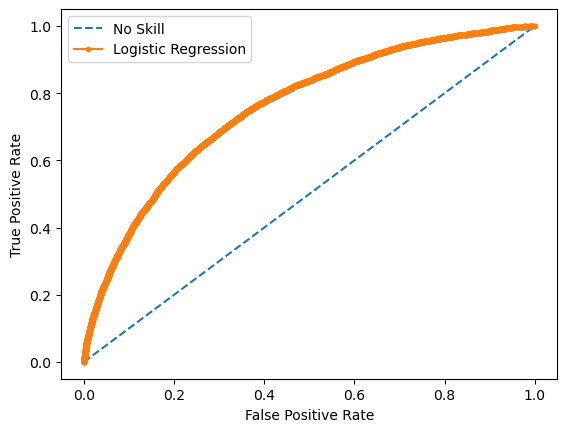

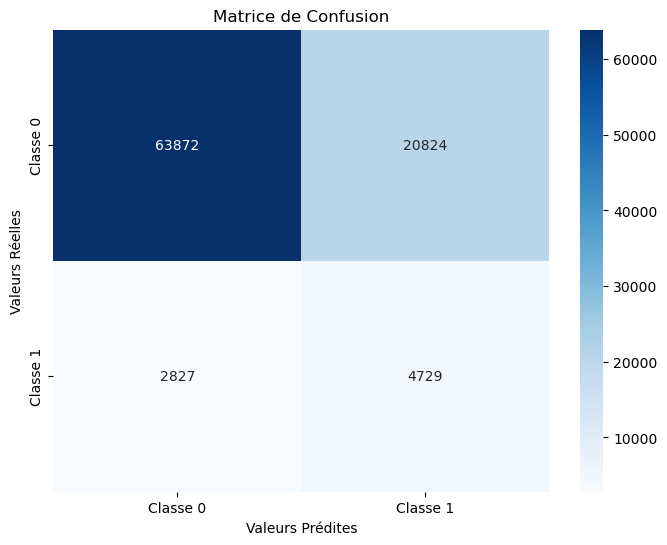

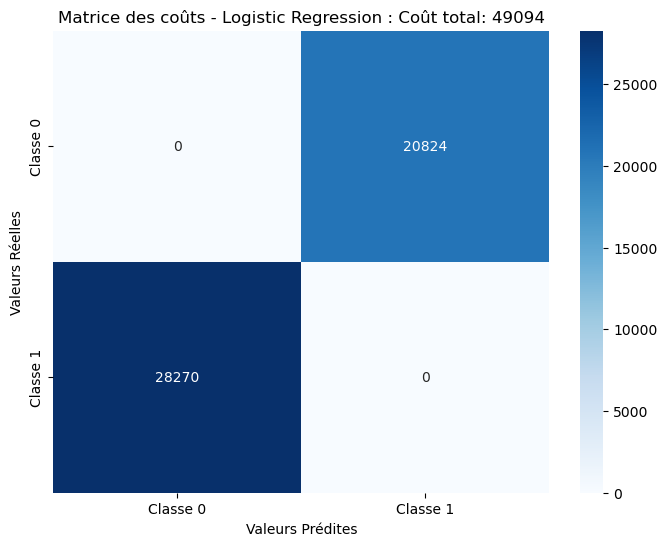

Model run : bb0da7b917814294815ffc6bc9c4d7c9


In [54]:
with mlflow.start_run(experiment_id=experiment.experiment_id, run_name='Logistic Regression'):
    training_model(lr_clf, X_train_samp, y_train_samp, threshold_score='custom')
    lr_classifier, lr_metrics = evaluate_model(lr_clf, X_train_samp, y_train_samp, X_val_scaled, y_val, "Logistic Regression", threshold_score='custom')
    predictions = lr_classifier.predict(X_train_samp)
    signature = infer_signature(X_train_samp, predictions)
    mlflow.log_params(best_lr_hyperparams)
    mlflow.sklearn.log_model(lr_clf, "Logistic Regression", signature=signature)
    print("Model run :", mlflow.active_run().info.run_uuid)
mlflow.end_run()

In [55]:
df_results = pd.DataFrame(data=[{'modèle': 'Logistic Regression', 'hyperparamètres': best_lr_hyperparams, **lr_metrics}])
df_results

,modèle,hyperparamètres,eval_acc,eval_prec,eval_recall,eval_f1_score,eval_custom_fbeta,eval_roc_auc,eval_custom_cost,eval_custom_score,training_time
0,Logistic Regression,"{'C': 0.2601, 'penalty': 'l1', 'tol': 0.0201}",0.743626,0.185066,0.62586,0.285663,0.479145,0.689996,49094,0.693653,3.348


**SVC**

In [56]:
experiment = mlflow.get_experiment_by_name("HomeCredit_Classifier_3_Model")

In [57]:
all_svc_runs = mlflow.search_runs(experiment_ids=experiment.experiment_id, filter_string="tags.mlflow.runName = 'SVC'")
# Recherche de la meilleure exécution parmi toutes les exécutions de régression logistique
best_svc_run = all_svc_runs.sort_values(by="metrics.mean_custom_score", ascending=False).iloc[0]

# Récupérer l'ID de la meilleure exécution de la régression logistique
best_svc_run_id = best_svc_run.run_id

# Récupérer les informations de la meilleure exécution de la régression logistique
best_svc_infos = mlflow.get_run(best_svc_run_id).to_dictionary()
print(best_svc_infos)

{'info': {'artifact_uri': 'mlflow-artifacts:/8/5de7e19f73d74cac84aac3eb6e1fa07b/artifacts', 'end_time': 1715250079593, 'experiment_id': '8', 'lifecycle_stage': 'active', 'run_id': '5de7e19f73d74cac84aac3eb6e1fa07b', 'run_name': 'SVC', 'run_uuid': '5de7e19f73d74cac84aac3eb6e1fa07b', 'start_time': 1715249953550, 'status': 'FINISHED', 'user_id': 'Antoine'}, 'data': {'metrics': {'mean_custom_score': 0.4659}, 'params': {'model__C': '0.8001', 'model__gamma': 'auto', 'model__tol': '0.9901'}, 'tags': {'mlflow.user': 'Antoine', 'mlflow.source.name': 'f:\\Utilisateur\\Documents\\Anaconda\\Miniconda3\\envs\\mlflow_env\\lib\\site-packages\\ipykernel_launcher.py', 'mlflow.source.type': 'LOCAL', 'mlflow.runName': 'SVC'}}, 'inputs': {'dataset_inputs': []}}


In [59]:
best_svc_hyperparams = {key.replace('model__', ''): value for key, value in best_svc_infos['data']['params'].items()}
print(best_svc_hyperparams)

{'C': '0.8001', 'gamma': 'auto', 'tol': '0.9901'}


In [60]:
best_svc_hyperparams = {'C': 0.8001, 'gamma': 'auto', 'tol': 0.9901}

In [61]:
# Définition du modèle :
svc_clf = SVC(random_state=random_state, class_weight='balanced', probability=True, max_iter = 250, **best_svc_hyperparams)

In [62]:
mlflow.set_experiment("HomeCredit_Classifier_3_Best_Models")

<Experiment: artifact_location='mlflow-artifacts:/7', creation_time=1715241449923, experiment_id='7', last_update_time=1715241449923, lifecycle_stage='active', name='HomeCredit_Classifier_3_Best_Models', tags={}>

In [63]:
experiment = mlflow.get_experiment_by_name("HomeCredit_Classifier_3_Best_Models")

Threshold=0.145, Score=0.8333
train_accuracy: 0.333
train_precision: 0.333
train_recall: 1.000
train_f1_score: 0.500
train_custom_fbeta: 0.818
train_roc_auc: 0.500
train_custom_cost: 39594.000
train_custom_score: 0.833
Threshold=0.282, Score=0.543
eval_accuracy: 0.828
eval_precision: 0.111
eval_recall: 0.156
eval_f1_score: 0.130
eval_custom_fbeta: 0.137
eval_roc_auc: 0.522
eval_custom_cost: 73241.000
eval_custom_score: 0.543
training_time: 42.901


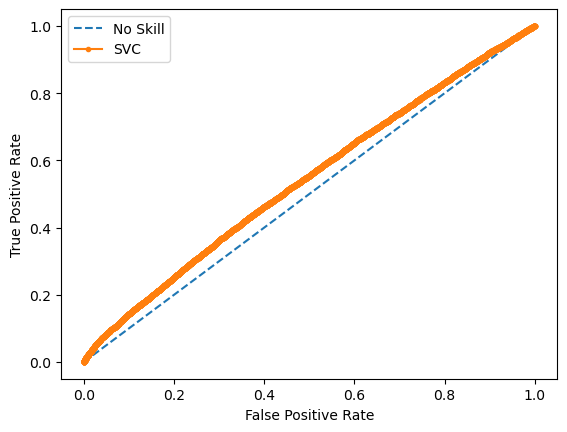

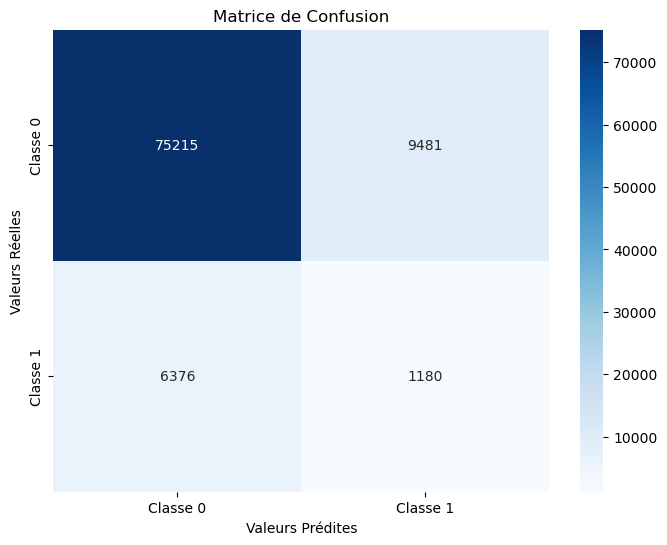

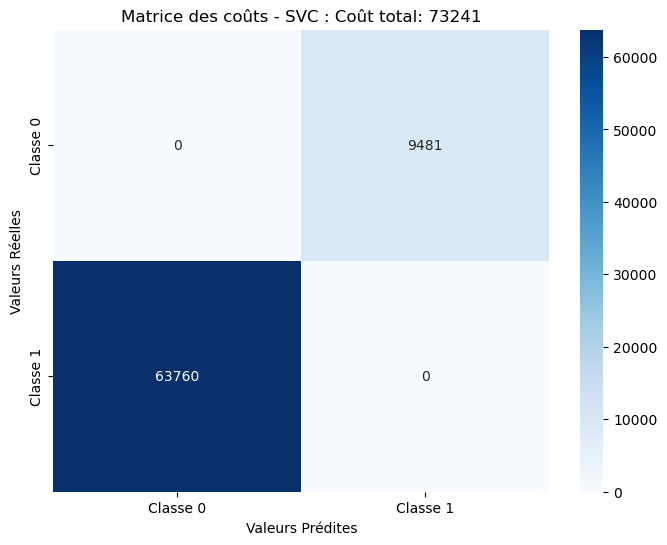

Model run : 0b6d086facba4691826f14ae9248f76c


In [64]:
with mlflow.start_run(experiment_id=experiment.experiment_id, run_name='SVC'):
    training_model(svc_clf, X_train_samp, y_train_samp, threshold_score='custom')
    svc_classifier, svc_metrics = evaluate_model(svc_clf, X_train_samp, y_train_samp, X_val_scaled, y_val, "SVC", threshold_score='custom')
    predictions = svc_classifier.predict(X_train_samp)
    signature = infer_signature(X_train_samp, predictions)
    mlflow.log_params(best_svc_hyperparams)
    mlflow.sklearn.log_model(svc_clf, "SVC", signature=signature)
    print("Model run :", mlflow.active_run().info.run_uuid)
mlflow.end_run()

In [65]:
df_tmp = pd.DataFrame(data=[{'modèle': 'SVC', 'hyperparamètres': best_svc_hyperparams, **svc_metrics}])
df_results = pd.concat([df_results, df_tmp], axis=0)
df_results

,modèle,hyperparamètres,eval_acc,eval_prec,eval_recall,eval_f1_score,eval_custom_fbeta,eval_roc_auc,eval_custom_cost,eval_custom_score,training_time
0,Logistic Regression,"{'C': 0.2601, 'penalty': 'l1', 'tol': 0.0201}",0.743626,0.185066,0.625860,0.285663,0.479145,0.689996,49094,0.693653,3.348
0,SVC,"{'C': 0.8001, 'gamma': 'auto', 'tol': 0.9901}",0.828112,0.110684,0.156167,0.129549,0.137070,0.522113,73241,0.542975,42.901


**RandomForest**

In [66]:
experiment = mlflow.get_experiment_by_name("HomeCredit_Classifier_3_Model")

In [67]:
all_rf_runs = mlflow.search_runs(experiment_ids=experiment.experiment_id, filter_string="tags.mlflow.runName = 'Random_Forest'")
# Recherche de la meilleure exécution parmi toutes les exécutions de régression logistique
best_rf_run = all_rf_runs.sort_values(by="metrics.mean_custom_score", ascending=False).iloc[0]

# Récupérer l'ID de la meilleure exécution de la régression logistique
best_rf_run_id = best_rf_run.run_id

# Récupérer les informations de la meilleure exécution de la régression logistique
best_rf_infos = mlflow.get_run(best_rf_run_id).to_dictionary()
print(best_rf_infos)

{'info': {'artifact_uri': 'mlflow-artifacts:/8/e778392354b5489cb3c4b3b910fb698e/artifacts', 'end_time': 1715250588860, 'experiment_id': '8', 'lifecycle_stage': 'active', 'run_id': 'e778392354b5489cb3c4b3b910fb698e', 'run_name': 'Random_Forest', 'run_uuid': 'e778392354b5489cb3c4b3b910fb698e', 'start_time': 1715250561265, 'status': 'FINISHED', 'user_id': 'Antoine'}, 'data': {'metrics': {'mean_custom_score': 0.6769}, 'params': {'max_depth': '30', 'max_samples': '0.6024768212339613', 'min_samples_leaf': '0.022563361649145627', 'min_samples_split': '0.0019879148977913668', 'n_estimators': '399'}, 'tags': {'mlflow.user': 'Antoine', 'mlflow.source.name': 'f:\\Utilisateur\\Documents\\Anaconda\\Miniconda3\\envs\\mlflow_env\\lib\\site-packages\\ipykernel_launcher.py', 'mlflow.source.type': 'LOCAL', 'mlflow.runName': 'Random_Forest'}}, 'inputs': {'dataset_inputs': []}}


In [68]:
best_rf_hyperparams = {key.replace('model__', ''): value for key, value in best_rf_infos['data']['params'].items()}
print(best_rf_hyperparams)

{'max_depth': '30', 'max_samples': '0.6024768212339613', 'min_samples_leaf': '0.022563361649145627', 'min_samples_split': '0.0019879148977913668', 'n_estimators': '399'}


In [69]:
best_rf_hyperparams = {'max_depth': 30, 'max_samples': 0.6024768212339613, 'min_samples_leaf': 0.022563361649145627, 'min_samples_split': 0.0019879148977913668, 'n_estimators': 399}

In [70]:
# Définition du modèle :
rf_clf = RandomForestClassifier(random_state=random_state, class_weight='balanced', **best_rf_hyperparams)

In [71]:
mlflow.set_experiment("HomeCredit_Classifier_3_Best_Models")

<Experiment: artifact_location='mlflow-artifacts:/7', creation_time=1715241449923, experiment_id='7', last_update_time=1715241449923, lifecycle_stage='active', name='HomeCredit_Classifier_3_Best_Models', tags={}>

In [72]:
experiment = mlflow.get_experiment_by_name("HomeCredit_Classifier_3_Best_Models")

Threshold=0.389, Score=0.8381
train_accuracy: 0.410
train_precision: 0.359
train_recall: 0.981
train_f1_score: 0.526
train_custom_fbeta: 0.821
train_roc_auc: 0.553
train_custom_cost: 38469.000
train_custom_score: 0.838
Threshold=0.495, Score=0.6722
eval_accuracy: 0.661
eval_precision: 0.152
eval_recall: 0.687
eval_f1_score: 0.249
eval_custom_fbeta: 0.482
eval_roc_auc: 0.673
eval_custom_cost: 52535.000
eval_custom_score: 0.672
training_time: 20.4866


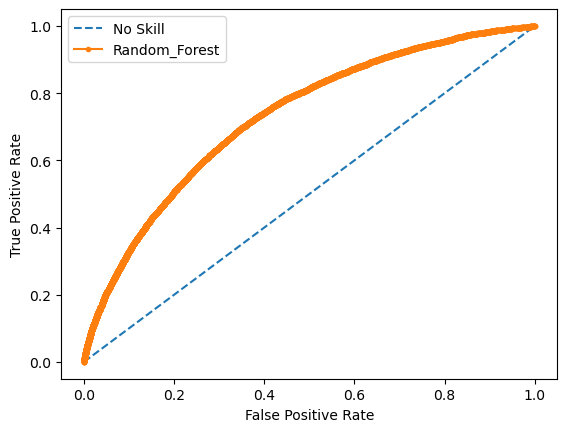

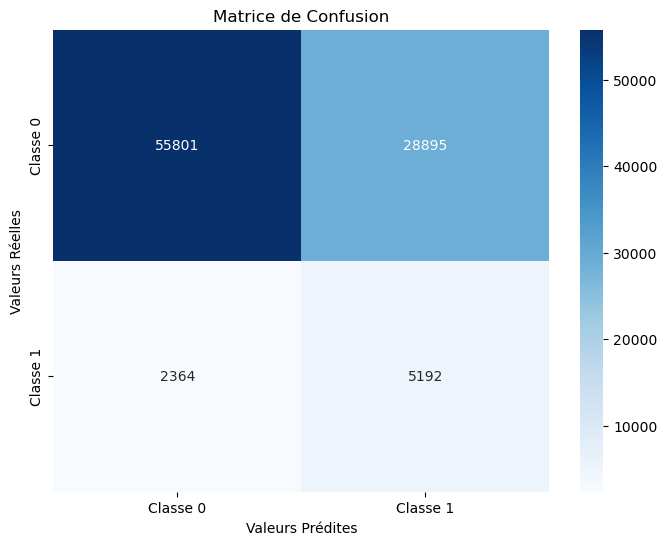

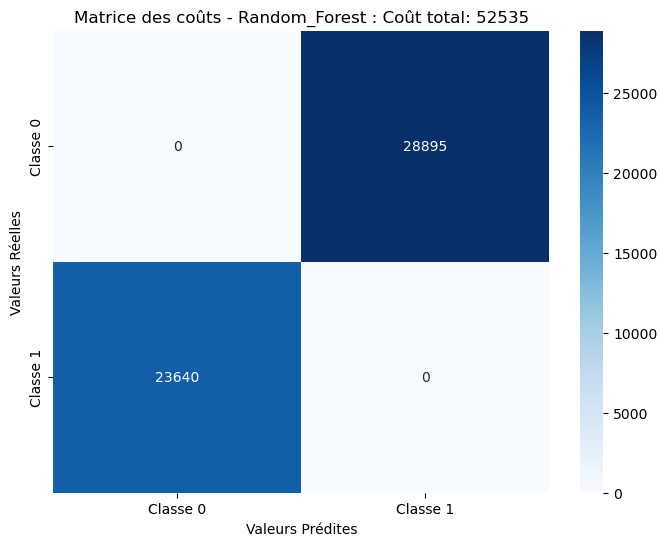

Model run : 1c0a9002796940a89acce77ef6a7510d


In [73]:
with mlflow.start_run(experiment_id=experiment.experiment_id, run_name='Random_Forest'):
    training_model(rf_clf, X_train_samp, y_train_samp, threshold_score='custom')
    rf_classifier, rf_metrics = evaluate_model(rf_clf, X_train_samp, y_train_samp, X_val_scaled, y_val, "Random_Forest", threshold_score='custom')
    predictions = rf_classifier.predict(X_train_samp)
    signature = infer_signature(X_train_samp, predictions)
    mlflow.log_params(best_rf_hyperparams)
    mlflow.sklearn.log_model(rf_clf, "Random_Forest", signature=signature)
    print("Model run :", mlflow.active_run().info.run_uuid)
mlflow.end_run()

In [74]:
df_tmp = pd.DataFrame(data=[{'modèle': 'Random Forest', 'hyperparamètres': best_rf_hyperparams, **rf_metrics}])
df_results = pd.concat([df_results, df_tmp], axis=0)
df_results

,modèle,hyperparamètres,eval_acc,eval_prec,eval_recall,eval_f1_score,eval_custom_fbeta,eval_roc_auc,eval_custom_cost,eval_custom_score,training_time
0,Logistic Regression,"{'C': 0.2601, 'penalty': 'l1', 'tol': 0.0201}",0.743626,0.185066,0.625860,0.285663,0.479145,0.689996,49094,0.693653,3.3480
0,SVC,"{'C': 0.8001, 'gamma': 'auto', 'tol': 0.9901}",0.828112,0.110684,0.156167,0.129549,0.137070,0.522113,73241,0.542975,42.9010
0,Random Forest,"{'max_depth': 30, 'max_samples': 0.60247682123...",0.661156,0.152316,0.687136,0.249358,0.482239,0.672987,52535,0.672181,20.4866


**XGBoost**

In [75]:
experiment = mlflow.get_experiment_by_name("HomeCredit_Classifier_3_Model")

In [76]:
all_xgb_runs = mlflow.search_runs(experiment_ids=experiment.experiment_id, filter_string="tags.mlflow.runName = 'XGBClassifier'")
# Recherche de la meilleure exécution parmi toutes les exécutions de régression logistique
best_xgb_run = all_xgb_runs.sort_values(by="metrics.mean_custom_score", ascending=False).iloc[0]

# Récupérer l'ID de la meilleure exécution de la régression logistique
best_xgb_run_id = best_xgb_run.run_id

# Récupérer les informations de la meilleure exécution de la régression logistique
best_xgb_infos = mlflow.get_run(best_xgb_run_id).to_dictionary()
print(best_xgb_infos)

{'info': {'artifact_uri': 'mlflow-artifacts:/8/f52af38ccd9a44ce850dc36c8e2f079d/artifacts', 'end_time': 1715249339598, 'experiment_id': '8', 'lifecycle_stage': 'active', 'run_id': 'f52af38ccd9a44ce850dc36c8e2f079d', 'run_name': 'XGBClassifier', 'run_uuid': 'f52af38ccd9a44ce850dc36c8e2f079d', 'start_time': 1715249315050, 'status': 'FINISHED', 'user_id': 'Antoine'}, 'data': {'metrics': {'mean_custom_score': 0.7086}, 'params': {'model__colsample_bytree': '0.5617809435435263', 'model__gamma': '0.8183653512052171', 'model__learning_rate': '0.34602206540715513', 'model__max_depth': '2', 'model__min_child_weight': '4', 'model__n_estimators': '670', 'model__reg_alpha': '7.072646017029539', 'model__reg_lambda': '0.024203593558907763', 'model__subsample': '0.7226431446959879'}, 'tags': {'mlflow.user': 'Antoine', 'mlflow.source.name': 'f:\\Utilisateur\\Documents\\Anaconda\\Miniconda3\\envs\\mlflow_env\\lib\\site-packages\\ipykernel_launcher.py', 'mlflow.source.type': 'LOCAL', 'mlflow.runName': 'X

In [77]:
best_xgb_hyperparams = {key.replace('model__', ''): value for key, value in best_xgb_infos['data']['params'].items()}
print(best_xgb_hyperparams)

{'colsample_bytree': '0.5617809435435263', 'gamma': '0.8183653512052171', 'learning_rate': '0.34602206540715513', 'max_depth': '2', 'min_child_weight': '4', 'n_estimators': '670', 'reg_alpha': '7.072646017029539', 'reg_lambda': '0.024203593558907763', 'subsample': '0.7226431446959879'}


In [78]:
best_xgb_hyperparams = {
    'colsample_bytree': 0.5617809435435263, 'gamma': 0.8183653512052171, 'learning_rate': 0.34602206540715513,
    'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 670, 'reg_alpha': 7.072646017029539,
    'reg_lambda': 0.024203593558907763, 'subsample': 0.7226431446959879
}

In [79]:
# Définition du modèle :
xgb_clf = XGBClassifier(random_state=random_state, scale_pos_weight=weight, objective='binary:logistic', **best_xgb_hyperparams)

In [80]:
mlflow.set_experiment("HomeCredit_Classifier_3_Best_Models")

<Experiment: artifact_location='mlflow-artifacts:/7', creation_time=1715241449923, experiment_id='7', last_update_time=1715241449923, lifecycle_stage='active', name='HomeCredit_Classifier_3_Best_Models', tags={}>

In [81]:
experiment = mlflow.get_experiment_by_name("HomeCredit_Classifier_3_Best_Models")

Threshold=0.208, Score=0.8636
train_accuracy: 0.554
train_precision: 0.426
train_recall: 0.967
train_f1_score: 0.591
train_custom_fbeta: 0.844
train_roc_auc: 0.657
train_custom_cost: 32408.000
train_custom_score: 0.864
Threshold=0.491, Score=0.7078
eval_accuracy: 0.740
eval_precision: 0.190
eval_recall: 0.664
eval_f1_score: 0.295
eval_custom_fbeta: 0.505
eval_roc_auc: 0.705
eval_custom_cost: 46827.000
eval_custom_score: 0.708
training_time: 4.2559


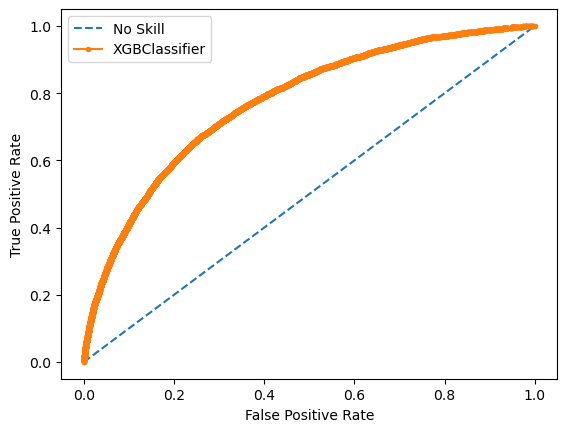

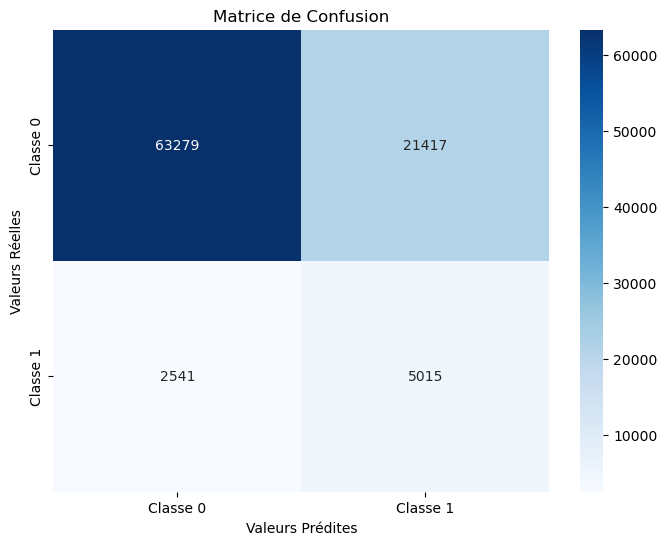

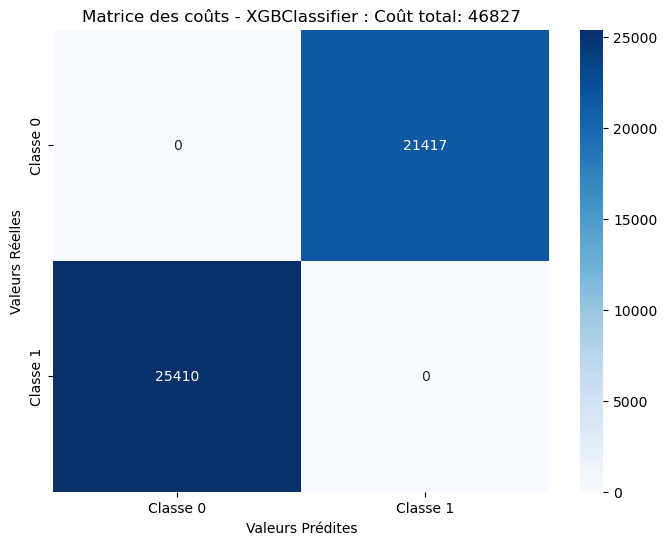

Model run : 495618f3fe6949c6ac81514ff40035cf


In [82]:
with mlflow.start_run(experiment_id=experiment.experiment_id, run_name='XGBClassifier'):
    training_model(xgb_clf, X_train_samp, y_train_samp, threshold_score='custom')
    xgb_classifier, xgb_metrics = evaluate_model(xgb_clf, X_train_samp, y_train_samp, X_val_scaled, y_val, "XGBClassifier", threshold_score='custom')
    predictions = xgb_classifier.predict(X_train_samp)
    signature = infer_signature(X_train_samp, predictions)
    mlflow.log_params(best_xgb_hyperparams)
    mlflow.sklearn.log_model(lr_clf, "XGBClassifier", signature=signature)
    print("Model run :", mlflow.active_run().info.run_uuid)
mlflow.end_run()

In [83]:
df_tmp = pd.DataFrame(data=[{'modèle': 'XGBClassifier', 'hyperparamètres': best_xgb_hyperparams, **xgb_metrics}])
df_results = pd.concat([df_results, df_tmp], axis=0)
df_results

,modèle,hyperparamètres,eval_acc,eval_prec,eval_recall,eval_f1_score,eval_custom_fbeta,eval_roc_auc,eval_custom_cost,eval_custom_score,training_time
0,Logistic Regression,"{'C': 0.2601, 'penalty': 'l1', 'tol': 0.0201}",0.743626,0.185066,0.625860,0.285663,0.479145,0.689996,49094,0.693653,3.3480
0,SVC,"{'C': 0.8001, 'gamma': 'auto', 'tol': 0.9901}",0.828112,0.110684,0.156167,0.129549,0.137070,0.522113,73241,0.542975,42.9010
0,Random Forest,"{'max_depth': 30, 'max_samples': 0.60247682123...",0.661156,0.152316,0.687136,0.249358,0.482239,0.672987,52535,0.672181,20.4866
0,XGBClassifier,"{'colsample_bytree': 0.5617809435435263, 'gamm...",0.740298,0.189732,0.663711,0.295104,0.504753,0.705421,46827,0.707799,4.2559


**LightGBM**

In [84]:
experiment = mlflow.get_experiment_by_name("HomeCredit_Classifier_3_Model")

In [85]:
all_lgmb_runs = mlflow.search_runs(experiment_ids=experiment.experiment_id, filter_string="tags.mlflow.runName = 'LGBMClassifier'")
# Recherche de la meilleure exécution parmi toutes les exécutions de régression logistique
best_lgmb_run = all_lgmb_runs.sort_values(by="metrics.mean_custom_score", ascending=False).iloc[0]

# Récupérer l'ID de la meilleure exécution de la régression logistique
best_lgmb_run_id = best_lgmb_run.run_id

# Récupérer les informations de la meilleure exécution de la régression logistique
best_lgmb_infos = mlflow.get_run(best_lgmb_run_id).to_dictionary()
print(best_lgmb_infos)

{'info': {'artifact_uri': 'mlflow-artifacts:/8/64131643f8ac43e4bf5740533f8f0838/artifacts', 'end_time': 1715248379270, 'experiment_id': '8', 'lifecycle_stage': 'active', 'run_id': '64131643f8ac43e4bf5740533f8f0838', 'run_name': 'LGBMClassifier', 'run_uuid': '64131643f8ac43e4bf5740533f8f0838', 'start_time': 1715248360238, 'status': 'FINISHED', 'user_id': 'Antoine'}, 'data': {'metrics': {'mean_custom_score': 0.7116}, 'params': {'model__colsample_bytree': '0.9803840371703639', 'model__learning_rate': '0.05111302246718142', 'model__max_depth': '19', 'model__min_child_weight': '0.07359068924845225', 'model__n_estimators': '494', 'model__num_leaves': '16', 'model__reg_alpha': '4.924903717527537', 'model__reg_lambda': '0.4249370831179553', 'model__subsample': '0.729655487336464'}, 'tags': {'mlflow.user': 'Antoine', 'mlflow.source.name': 'f:\\Utilisateur\\Documents\\Anaconda\\Miniconda3\\envs\\mlflow_env\\lib\\site-packages\\ipykernel_launcher.py', 'mlflow.source.type': 'LOCAL', 'mlflow.runNam

In [86]:
best_lgmb_hyperparams = {key.replace('model__', ''): value for key, value in best_lgmb_infos['data']['params'].items()}
print(best_lgmb_hyperparams)

{'colsample_bytree': '0.9803840371703639', 'learning_rate': '0.05111302246718142', 'max_depth': '19', 'min_child_weight': '0.07359068924845225', 'n_estimators': '494', 'num_leaves': '16', 'reg_alpha': '4.924903717527537', 'reg_lambda': '0.4249370831179553', 'subsample': '0.729655487336464'}


In [87]:
best_lgmb_hyperparams = {
    'colsample_bytree': 0.9803840371703639, 'learning_rate': 0.05111302246718142, 'max_depth': 19, 'min_child_weight': 0.07359068924845225,
    'n_estimators': 494, 'num_leaves': 16, 'reg_alpha': 4.924903717527537, 'reg_lambda': 0.4249370831179553, 'subsample': 0.729655487336464
}

In [88]:
# Définition du modèle :t
lgbm_clf = LGBMClassifier(random_state=random_state, class_weight = 'balanced', objective='binary', **best_lgmb_hyperparams)

In [89]:
mlflow.set_experiment("HomeCredit_Classifier_3_Best_Models")

<Experiment: artifact_location='mlflow-artifacts:/7', creation_time=1715241449923, experiment_id='7', last_update_time=1715241449923, lifecycle_stage='active', name='HomeCredit_Classifier_3_Best_Models', tags={}>

In [90]:
experiment = mlflow.get_experiment_by_name("HomeCredit_Classifier_3_Best_Models")

[LightGBM] [Info] Number of positive: 19798, number of negative: 39596
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24715
[LightGBM] [Info] Number of data points in the train set: 59394, number of used features: 250
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Threshold=0.229, Score=0.8662
train_accuracy: 0.563
train_precision: 0.431
train_recall: 0.967
train_f1_score: 0.596
train_custom_fbeta: 0.847
train_roc_auc: 0.664
train_custom_cost: 31793.000
train_custom_score: 0.866
[LightGBM] [Info] Number of positive: 19798, number of negative: 39596
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019555 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `f

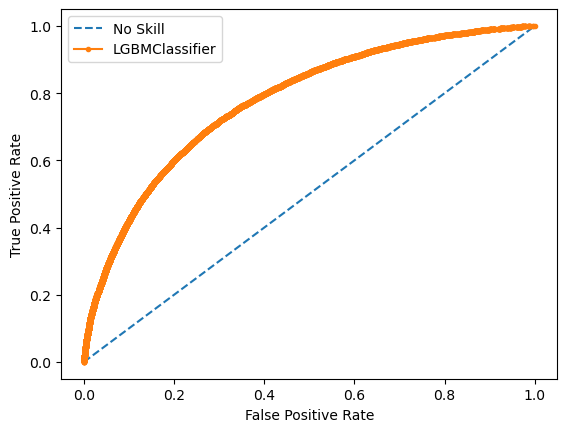

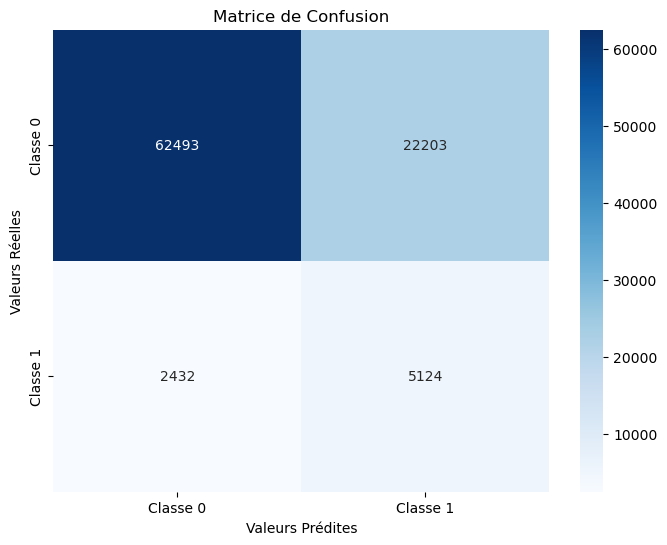

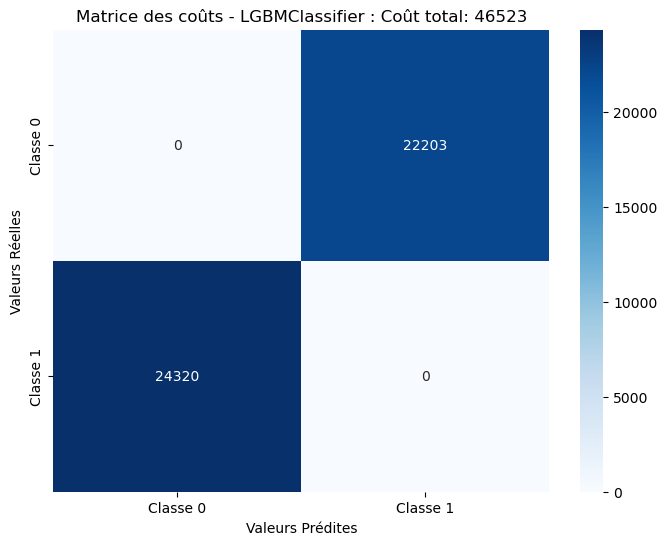

Model run : 91f9fb0fe22749d885be4f8a386133cf


In [91]:
with mlflow.start_run(experiment_id=experiment.experiment_id, run_name='LGBMClassifier'):
    training_model(lgbm_clf, X_train_samp, y_train_samp, threshold_score='custom')
    lgbm_classifier, lgbm_metrics = evaluate_model(lgbm_clf, X_train_samp, y_train_samp, X_val_scaled, y_val, "LGBMClassifier", threshold_score='custom')
    predictions = lgbm_classifier.predict(X_train_samp)
    signature = infer_signature(X_train_samp, predictions)
    mlflow.log_params(best_lgmb_hyperparams)
    mlflow.sklearn.log_model(lgbm_clf, "LGBMClassifier", signature=signature)
    print("Model run :", mlflow.active_run().info.run_uuid)
mlflow.end_run()

In [92]:
df_tmp = pd.DataFrame(data=[{'modèle': 'LGBMClassifier', 'hyperparamètres': best_lgmb_hyperparams, **lgbm_metrics}])
df_results = pd.concat([df_results, df_tmp], axis=0)
df_results

,modèle,hyperparamètres,eval_acc,eval_prec,eval_recall,eval_f1_score,eval_custom_fbeta,eval_roc_auc,eval_custom_cost,eval_custom_score,training_time
0,Logistic Regression,"{'C': 0.2601, 'penalty': 'l1', 'tol': 0.0201}",0.743626,0.185066,0.625860,0.285663,0.479145,0.689996,49094,0.693653,3.3480
0,SVC,"{'C': 0.8001, 'gamma': 'auto', 'tol': 0.9901}",0.828112,0.110684,0.156167,0.129549,0.137070,0.522113,73241,0.542975,42.9010
0,Random Forest,"{'max_depth': 30, 'max_samples': 0.60247682123...",0.661156,0.152316,0.687136,0.249358,0.482239,0.672987,52535,0.672181,20.4866
0,XGBClassifier,"{'colsample_bytree': 0.5617809435435263, 'gamm...",0.740298,0.189732,0.663711,0.295104,0.504753,0.705421,46827,0.707799,4.2559
0,LGBMClassifier,"{'colsample_bytree': 0.9803840371703639, 'lear...",0.732960,0.187507,0.678137,0.293782,0.511230,0.707994,46523,0.709696,3.7104


In [93]:
df_results_sorted = df_results.sort_values('eval_custom_cost')
df_results_sorted

,modèle,hyperparamètres,eval_acc,eval_prec,eval_recall,eval_f1_score,eval_custom_fbeta,eval_roc_auc,eval_custom_cost,eval_custom_score,training_time
0,LGBMClassifier,"{'colsample_bytree': 0.9803840371703639, 'lear...",0.732960,0.187507,0.678137,0.293782,0.511230,0.707994,46523,0.709696,3.7104
0,XGBClassifier,"{'colsample_bytree': 0.5617809435435263, 'gamm...",0.740298,0.189732,0.663711,0.295104,0.504753,0.705421,46827,0.707799,4.2559
0,Logistic Regression,"{'C': 0.2601, 'penalty': 'l1', 'tol': 0.0201}",0.743626,0.185066,0.625860,0.285663,0.479145,0.689996,49094,0.693653,3.3480
0,Random Forest,"{'max_depth': 30, 'max_samples': 0.60247682123...",0.661156,0.152316,0.687136,0.249358,0.482239,0.672987,52535,0.672181,20.4866
0,SVC,"{'C': 0.8001, 'gamma': 'auto', 'tol': 0.9901}",0.828112,0.110684,0.156167,0.129549,0.137070,0.522113,73241,0.542975,42.9010


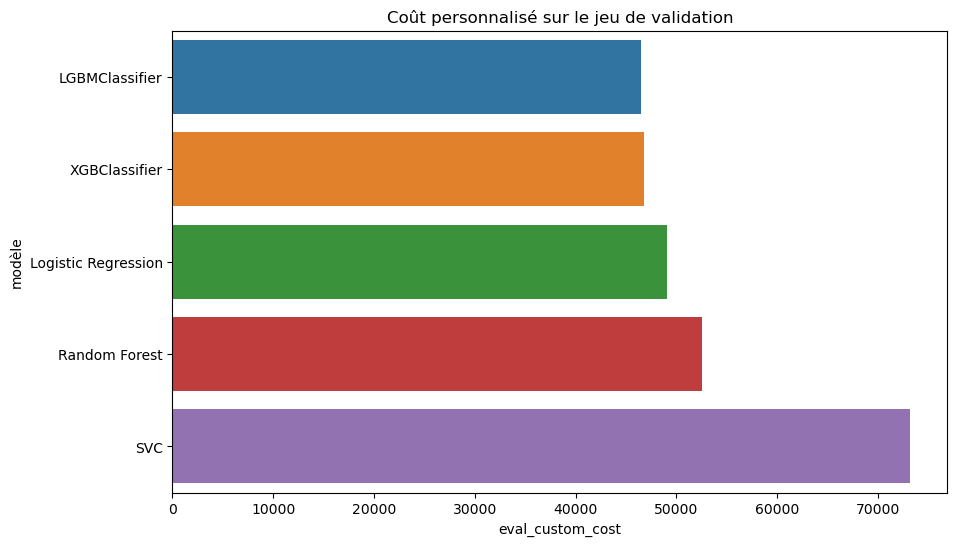

In [94]:
plt.figure(figsize=(10, 6))
sns.barplot(x='eval_custom_cost', y='modèle', data=df_results_sorted)
plt.title('Coût personnalisé sur le jeu de validation')
plt.show()

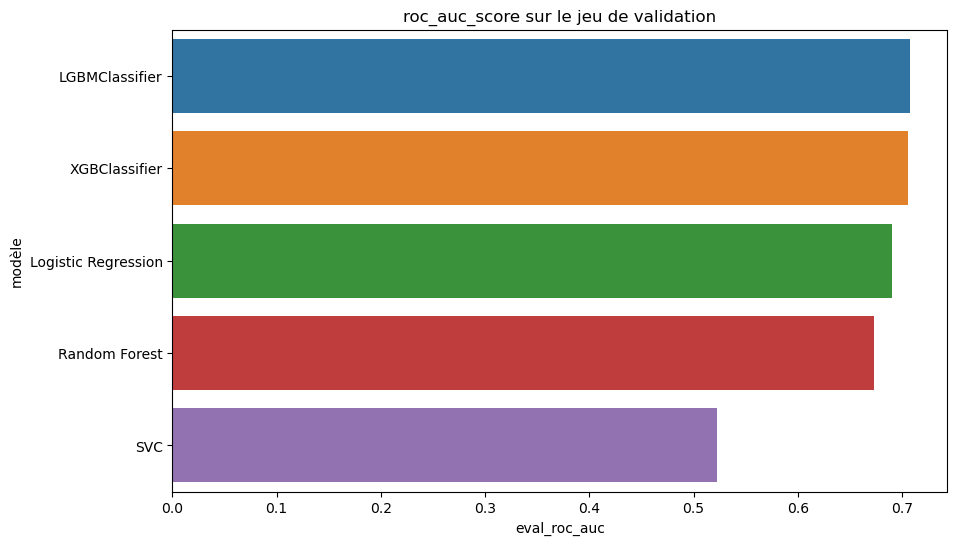

In [95]:
plt.figure(figsize=(10, 6))
sns.barplot(x='eval_roc_auc', y='modèle', data=df_results_sorted)
plt.title('roc_auc_score sur le jeu de validation')
plt.show()

In [96]:
# Enregistrement du dataframe des résultats :
df_results_sorted.to_csv("df_results_sorted_v2.csv", index=False)

In [22]:
# Je récupère le dataframe des résultats pour comparer les modèles en terme de temps d'entrainement : 
df_results_sorted = pd.read_csv("df_results_sorted_v2.csv")

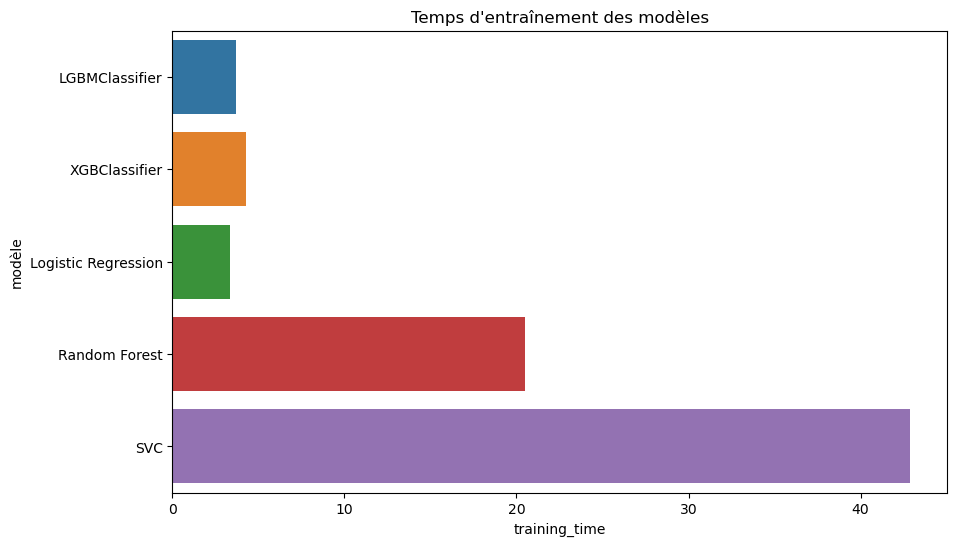

In [23]:
# Comparaison des modèles en terme de temps d'entraînement :
plt.figure(figsize=(10, 6))
sns.barplot(x='training_time', y='modèle', data=df_results_sorted)
plt.title('Temps d\'entraînement des modèles')
plt.show()

Le modèle permettant de limiter au maximum les coûts engendrés par le fait de prédire qu'un client n'aura pas de difficultés à rembourser son crédit alors qu'en réalité si est le LGBMClassifier.

L'observation des matrices de confusion nous montre qu'en réalité le nombre de mauvaises prédictions est légèrement moins élevé pour le XGBClassifier : 23 084 que pour le LGBMClassifier : 24 650. Mais notre métrique montre que les erreurs faites par ce dernier sont moins coûteuses pour l'entreprise.

### Test calibration sur le meilleur modèle :

In [97]:
# Le meilleur modèle était donc le suivant :

lgbm_clf = LGBMClassifier(random_state=random_state, class_weight = 'balanced', objective='binary', **best_lgmb_hyperparams)

In [98]:
# On utilise un CalibratedClassifierCV sur ce modèle :

calibrated_lgbm = CalibratedClassifierCV(lgbm_clf, method='isotonic', cv=3)

In [99]:
mlflow.set_experiment("HomeCredit_Classifier_3_Best_Models")

<Experiment: artifact_location='mlflow-artifacts:/7', creation_time=1715241449923, experiment_id='7', last_update_time=1715241449923, lifecycle_stage='active', name='HomeCredit_Classifier_3_Best_Models', tags={}>

In [100]:
experiment = mlflow.get_experiment_by_name("HomeCredit_Classifier_3_Best_Models")

[LightGBM] [Info] Number of positive: 13199, number of negative: 26397
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010603 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25037
[LightGBM] [Info] Number of data points in the train set: 39596, number of used features: 247
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 13199, number of negative: 26397
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25016
[LightGBM] [Info] Number of data points in the train set: 39596, number of used features: 245
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.00000

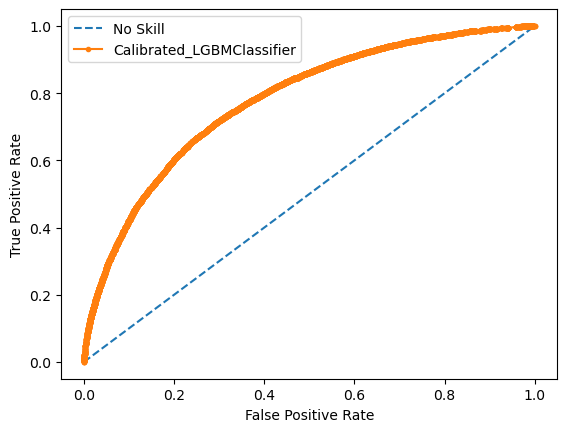

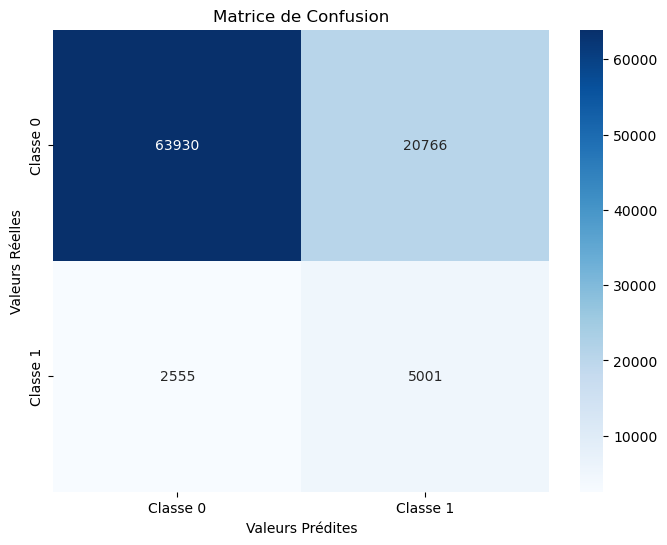

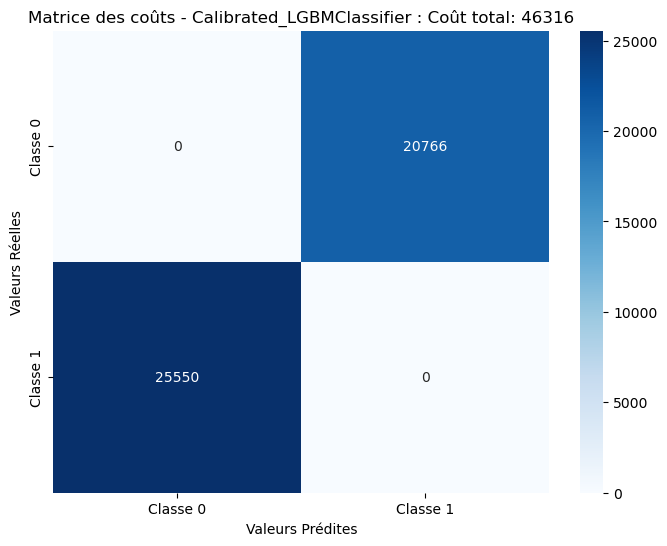

Model run : bf5e01b561f846e0a4383eec9a70b66f


In [101]:
with mlflow.start_run(experiment_id=experiment.experiment_id, run_name='Calibrated_LGBMClassifier'):
    training_model(calibrated_lgbm, X_train_samp, y_train_samp, threshold_score='custom')
    calibrated_lgbm_classifier, calibrated_lgbm_metrics = evaluate_model(calibrated_lgbm, X_train_samp, y_train_samp, X_val_scaled, y_val, "Calibrated_LGBMClassifier", threshold_score='custom')
    predictions = calibrated_lgbm_classifier.predict(X_train_samp)
    signature = infer_signature(X_train_samp, predictions)
    mlflow.log_params(best_lgmb_hyperparams)
    mlflow.sklearn.log_model(calibrated_lgbm, "Calibrated_LGBMClassifier", signature=signature)
    print("Model run :", mlflow.active_run().info.run_uuid)
mlflow.end_run()

In [102]:
df_best_results= pd.DataFrame(data=[{'modèle': 'LGBMClassifier', 'hyperparamètres': best_lgmb_hyperparams, **lgbm_metrics}])
df_tmp = pd.DataFrame(data=[{'modèle': 'Calibrated_LGBMClassifier_cust_th', 'hyperparamètres': best_lgmb_hyperparams, **calibrated_lgbm_metrics}])
df_best_results = pd.concat([df_best_results, df_tmp], axis = 0)
df_best_results

,modèle,hyperparamètres,eval_acc,eval_prec,eval_recall,eval_f1_score,eval_custom_fbeta,eval_roc_auc,eval_custom_cost,eval_custom_score,training_time
0,LGBMClassifier,"{'colsample_bytree': 0.9803840371703639, 'lear...",0.732960,0.187507,0.678137,0.293782,0.511230,0.707994,46523,0.709696,3.7104
0,Calibrated_LGBMClassifier_cust_th,"{'colsample_bytree': 0.9803840371703639, 'lear...",0.747203,0.194085,0.661858,0.300153,0.507035,0.708338,46316,0.710987,8.0954


Les performances sont légèrement améliorées par cette calibration, du moins concernant la métrique 'roc_auc_score' ainsi que notre métrique métier. On prédit un peu plus de faux négatifs, on améliore nos prédictions de vrais négatifs.

Je fais une tentative en utilisant cette fois le roc_auc_score pour déterminer le seuil de probabilité : 

[LightGBM] [Info] Number of positive: 13199, number of negative: 26397
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25037
[LightGBM] [Info] Number of data points in the train set: 39596, number of used features: 247
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 13199, number of negative: 26397
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25016
[LightGBM] [Info] Number of data points in the train set: 39596, number of used features: 245
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGB

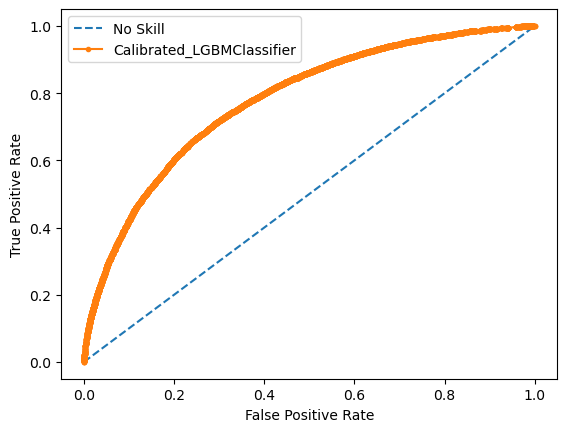

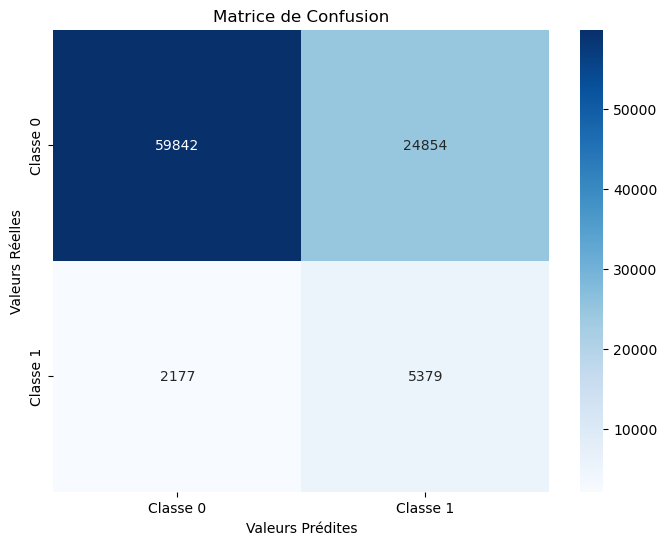

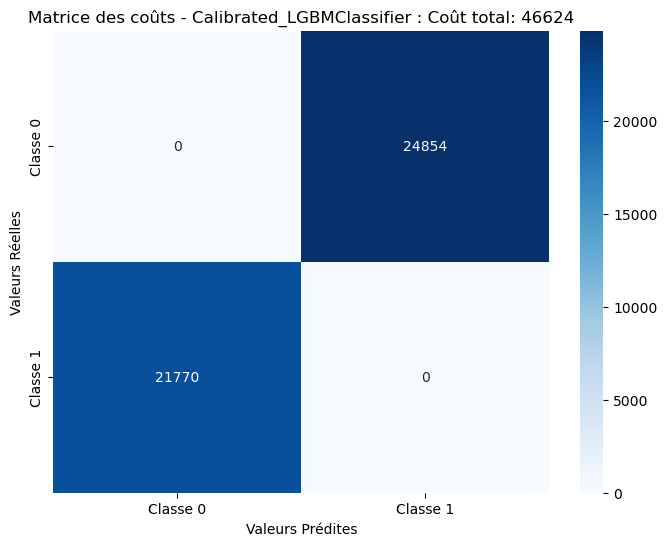

Model run : 589ea7af1d52433588f037aecb16aea8


In [103]:
with mlflow.start_run(experiment_id=experiment.experiment_id, run_name='Calibrated_LGBMClassifier_auc_thresh'):
    training_model(calibrated_lgbm, X_train_samp, y_train_samp, threshold_score='roc_auc')
    calibrated_roc_lgbm_classifier, calibrated_roc_lgbm_metrics_roc = evaluate_model(calibrated_lgbm, X_train_samp, y_train_samp, X_val_scaled, y_val, "Calibrated_LGBMClassifier", threshold_score='roc_auc')
    predictions = calibrated_roc_lgbm_classifier.predict(X_train_samp)
    signature = infer_signature(X_train_samp, predictions)
    mlflow.log_params(best_lgmb_hyperparams)
    mlflow.sklearn.log_model(calibrated_lgbm, "Calibrated_LGBMClassifier", signature=signature)
    print("Model run :", mlflow.active_run().info.run_uuid)
mlflow.end_run()

In [104]:
df_tmp = pd.DataFrame(data=[{'modèle': 'Calibrated_LGBMClassifier_roc_auc_th', 'hyperparamètres': best_lgmb_hyperparams, **calibrated_roc_lgbm_metrics_roc}])
df_best_results = pd.concat([df_best_results, df_tmp], axis = 0)
df_best_results

,modèle,hyperparamètres,eval_acc,eval_prec,eval_recall,eval_f1_score,eval_custom_fbeta,eval_roc_auc,eval_custom_cost,eval_custom_score,training_time
0,LGBMClassifier,"{'colsample_bytree': 0.9803840371703639, 'lear...",0.732960,0.187507,0.678137,0.293782,0.511230,0.707994,46523,0.709696,3.7104
0,Calibrated_LGBMClassifier_cust_th,"{'colsample_bytree': 0.9803840371703639, 'lear...",0.747203,0.194085,0.661858,0.300153,0.507035,0.708338,46316,0.710987,8.0954
0,Calibrated_LGBMClassifier_roc_auc_th,"{'colsample_bytree': 0.9803840371703639, 'lear...",0.706987,0.177918,0.711885,0.284686,0.521350,0.709218,46624,0.709065,8.0603


On obtient de moins bons résultats ici.

Même si on obtient des résultats légèrement moins satisfaisants, la calibration augmente la confiance qu'on peut avoir dans les probablités prédites par le modèle. Nous retiendrons donc le modèle LGMB auquel on applique la calibration, avec le seuil optimisé selon notre métrique personnalisé.

In [105]:
calibrated_lgbm = CalibratedClassifierCV(lgbm_clf, method='isotonic', cv=3)

In [106]:
mlflow.set_experiment("HomeCredit_Classifier_3_Registered_Model")

2024/05/09 14:45:19 INFO mlflow.tracking.fluent: Experiment with name 'HomeCredit_Classifier_3_Registered_Model' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/9', creation_time=1715258719201, experiment_id='9', last_update_time=1715258719201, lifecycle_stage='active', name='HomeCredit_Classifier_3_Registered_Model', tags={}>

In [107]:
experiment = mlflow.get_experiment_by_name("HomeCredit_Classifier_3_Registered_Model")

In [109]:
calibrated_lgbm.fit(X_train_samp, y_train_samp)

[LightGBM] [Info] Number of positive: 13199, number of negative: 26397
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25037
[LightGBM] [Info] Number of data points in the train set: 39596, number of used features: 247
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 13199, number of negative: 26397
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25016
[LightGBM] [Info] Number of data points in the train set: 39596, number of used features: 245
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGB

CalibratedClassifierCV(cv=3,
                       estimator=LGBMClassifier(class_weight='balanced',
                                                colsample_bytree=0.9803840371703639,
                                                learning_rate=0.05111302246718142,
                                                max_depth=19,
                                                min_child_weight=0.07359068924845225,
                                                n_estimators=494, num_leaves=16,
                                                objective='binary',
                                                random_state=42,
                                                reg_alpha=4.924903717527537,
                                                reg_lambda=0.4249370831179553,
                                                subsample=0.729655487336464),
                       method='isotonic')

In [110]:
# Log a model as an artifact to MLflow Tracking.
# Commencer un suivi d'exécution MLflow
mlflow.start_run(experiment_id=experiment.experiment_id, run_name='Register_Calibrated_LGBMClassifier')

# Enregistrer le modèle
mlflow.sklearn.log_model(calibrated_lgbm, "Calibrated_LGBMClassifier")

# Ajouter des métriques, tags ou des informations supplémentaires
mlflow.log_metrics(calibrated_lgbm_metrics)
mlflow.log_params(best_lgmb_hyperparams)
mlflow.set_tag("version", "1.0")

# Fermer l'exécution MLflow
mlflow.end_run()

In [111]:
# Register model from local filesystem

model_uri = "mlflow-artifacts:/6/cb400328769b4beaaad849711ab7c7d7/artifacts/Calibrated_LGBMClassifier"
model_name = "Calibrated_LGBMClassifier"
# model_version = "1"  # Update with the appropriate version number

mlflow.register_model(model_uri, model_name)


Registered model 'Calibrated_LGBMClassifier' already exists. Creating a new version of this model...
2024/05/09 14:46:57 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Calibrated_LGBMClassifier, version 3
Created version '3' of model 'Calibrated_LGBMClassifier'.


<ModelVersion: aliases=[], creation_timestamp=1715258817915, current_stage='None', description='', last_updated_timestamp=1715258817915, name='Calibrated_LGBMClassifier', run_id='', run_link='', source='mlflow-artifacts:/6/cb400328769b4beaaad849711ab7c7d7/artifacts/Calibrated_LGBMClassifier', status='READY', status_message='', tags={}, user_id='', version='3'>

In [112]:
print(classification_report(y_val, calibrated_lgbm.predict(X_val_scaled)))

              precision    recall  f1-score   support

           0       0.95      0.88      0.91     84696
           1       0.26      0.47      0.33      7556

    accuracy                           0.84     92252
   macro avg       0.60      0.67      0.62     92252
weighted avg       0.89      0.84      0.86     92252



In [7]:
# je réentraine le modèle avec les données scalées :
# Transformation par MinMaxScaler :
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Application over/under sampling sur jeu d'entraînement :
over_sampler = SMOTE(sampling_strategy=0.1)
under_sampler = RandomUnderSampler(sampling_strategy=0.5)
pipe_samp = imbpipeline(steps = [('over', over_sampler), ('under', under_sampler)])
X_train_samp, y_train_samp = pipe_samp.fit_resample(X_train_scaled, y_train)

In [114]:
calibrated_lgbm = CalibratedClassifierCV(lgbm_clf, method='isotonic', cv=3)

In [115]:
calibrated_lgbm.fit(X_train_samp, y_train_samp)

[LightGBM] [Info] Number of positive: 13199, number of negative: 26397
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25012
[LightGBM] [Info] Number of data points in the train set: 39596, number of used features: 248
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 13199, number of negative: 26397
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25025
[LightGBM] [Info] Number of data points in the train set: 39596, number of used features: 248
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGB

CalibratedClassifierCV(cv=3,
                       estimator=LGBMClassifier(class_weight='balanced',
                                                colsample_bytree=0.9803840371703639,
                                                learning_rate=0.05111302246718142,
                                                max_depth=19,
                                                min_child_weight=0.07359068924845225,
                                                n_estimators=494, num_leaves=16,
                                                objective='binary',
                                                random_state=42,
                                                reg_alpha=4.924903717527537,
                                                reg_lambda=0.4249370831179553,
                                                subsample=0.729655487336464),
                       method='isotonic')

In [116]:
# Enregistrement du scaler et du modèle avec pickle :
with open("scaler_v2.pkl", "wb") as f:
    pickle.dump(scaler, f)

In [117]:
with open("calibrated_lgbm_v2.pkl", "wb") as f:
    pickle.dump(calibrated_lgbm, f)

### Feature Importance

In [9]:
import shap
shap.initjs()

In [119]:
# Log a model as an artifact to MLflow Tracking.
# mlflow.sklearn.log_model(calibrated_lgbm, "mlflow-artifacts:/2/c88260c055254351b7dfd279c6275812/artifacts/Calibrated_LGBMClassifier")

In [120]:
# Je récupère mon modèle :
model = mlflow.sklearn.load_model("mlflow-artifacts:/9/cf1a7b93b67940cdbc614227434c8853/artifacts/Calibrated_LGBMClassifier")

In [10]:
feature_names = X_train.columns.to_list()

In [11]:
# Le meilleur modèle était donc le suivant :
random_state = 42
best_lgmb_hyperparams = {
    'colsample_bytree': 0.9803840371703639, 'learning_rate': 0.05111302246718142, 'max_depth': 19, 'min_child_weight': 0.07359068924845225,
    'n_estimators': 494, 'num_leaves': 16, 'reg_alpha': 4.924903717527537, 'reg_lambda': 0.4249370831179553, 'subsample': 0.729655487336464
}

lgbm_clf = LGBMClassifier(random_state=random_state, class_weight = 'balanced', objective='binary', **best_lgmb_hyperparams)

In [12]:
lgbm_clf.fit(X_train_samp, y_train_samp)

[LightGBM] [Info] Number of positive: 19798, number of negative: 39596
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24531
[LightGBM] [Info] Number of data points in the train set: 59394, number of used features: 251
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(class_weight='balanced', colsample_bytree=0.9803840371703639,
               learning_rate=0.05111302246718142, max_depth=19,
               min_child_weight=0.07359068924845225, n_estimators=494,
               num_leaves=16, objective='binary', random_state=42,
               reg_alpha=4.924903717527537, reg_lambda=0.4249370831179553,
               subsample=0.729655487336464)

In [13]:
# Explain the model's predictions using SHAP
explainer = shap.TreeExplainer(lgbm_clf)
shap_values = explainer.shap_values(X_val_scaled)

In [135]:
# Sauvegarde du shap explainer :
with open("shap_explainer_v2.pkl", "wb") as f:
    pickle.dump(explainer, f)

#### Absolute mean shap

Ici on peut visualiser les variables que le modèle a considéré comme les plus importantes pour la prédiction finale.

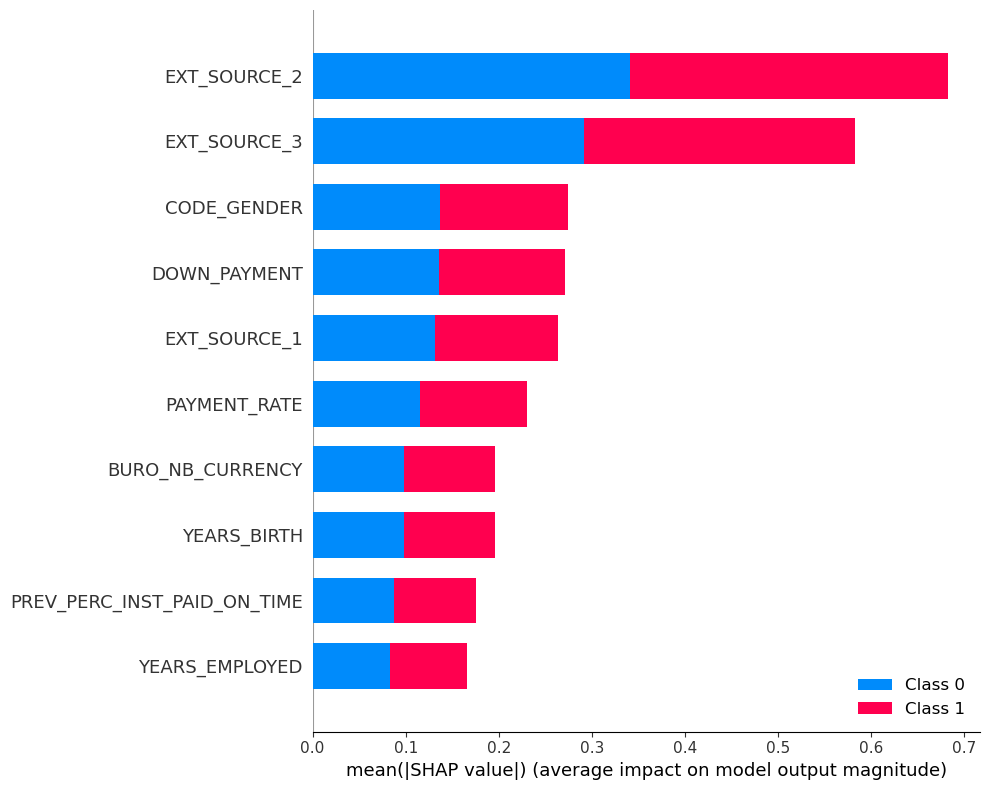

In [14]:
# Visualize the SHAP values
shap.summary_plot(shap_values, X_val_scaled, plot_type="bar", feature_names = feature_names, max_display=10, plot_size=(10.0,8.0))

### Visualisation par type de prédiction

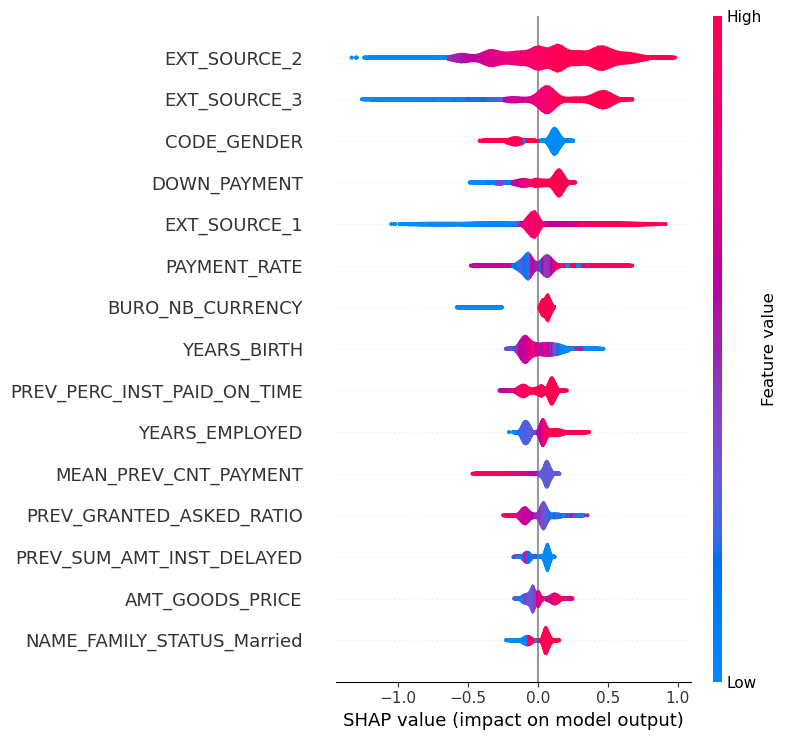

In [15]:
# Pour les prédictions de non difficultés à rembourser, y=0 :
shap.summary_plot(shap_values[0], X_val_scaled, feature_names=feature_names, plot_type='violin', max_display=15)

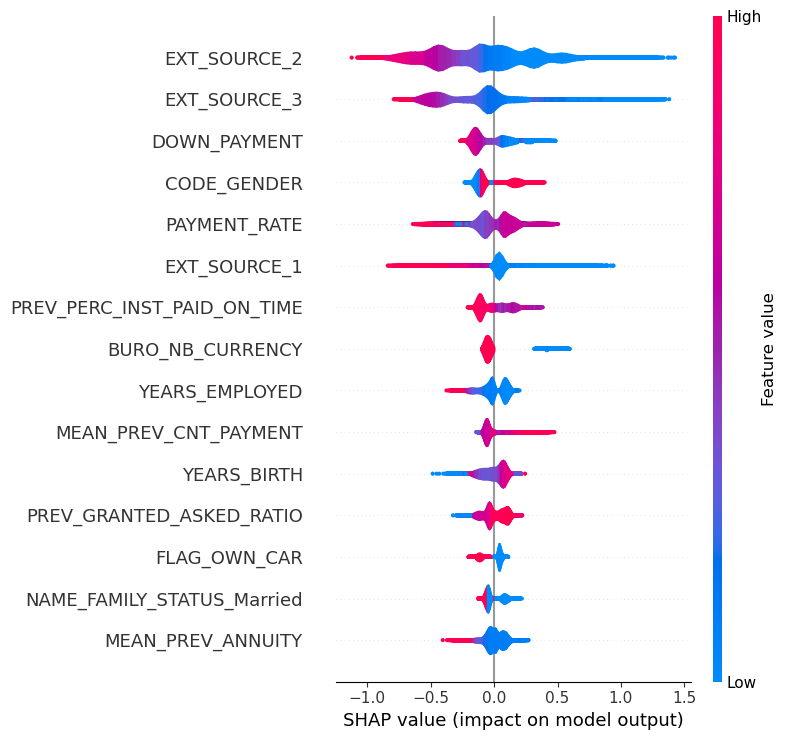

In [128]:
# Pour les prédictions de difficultés à rembourser, y=1 :
shap.summary_plot(shap_values[1], X_val_scaled, feature_names=feature_names, plot_type='violin', max_display=15)

### Feature Importance locale :

In [27]:
# On sélectionne un individu au hasard dans le jeu de validation :
sample = np.random.randint(0, X_val.shape[0])
print(sample)
sample_idx = sample
sample_test_data = X_val_scaled[sample_idx].reshape(1, -1).round(2)

# shap_vals = explainer.shap_values(sample_test_data)

51017


In [28]:
# Force plot pour cet individu :
shap.force_plot(explainer.expected_value[1], shap_values[1][sample_idx], sample_test_data, feature_names=feature_names)

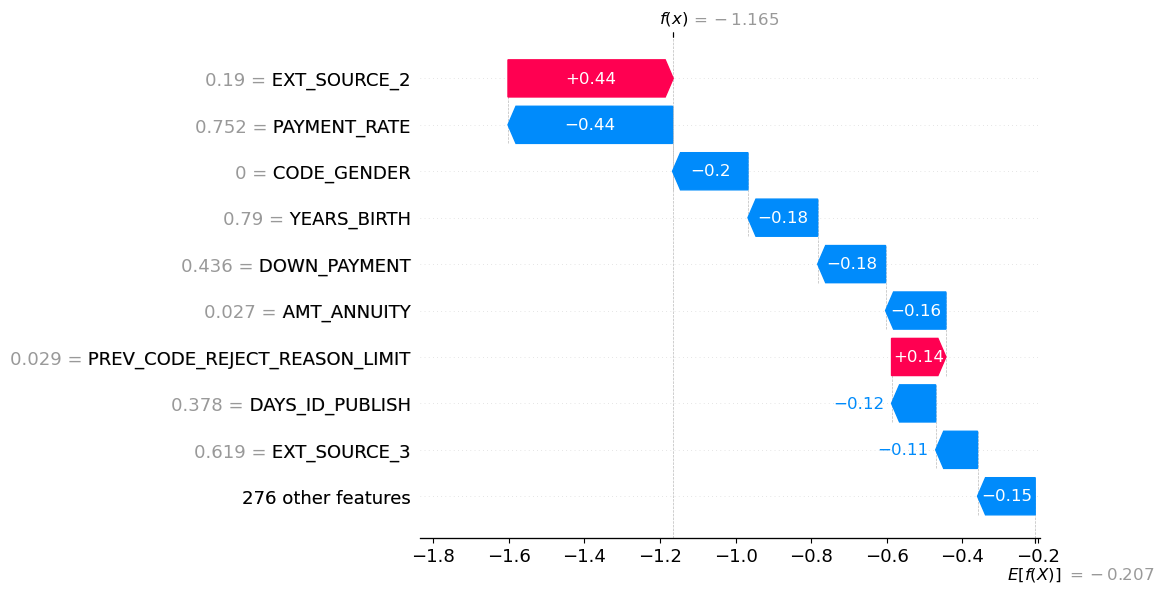

In [29]:
# Graphique d'explication individuelle détaillé
shap.waterfall_plot(shap.Explanation(values=shap_values[1][sample_idx], 
                                     base_values=explainer.expected_value[1], 
                                     data=X_val_scaled[sample_idx],
                                     feature_names=feature_names))

#### Test sur un autre individu

In [30]:
# Graphique de force pour une prédiction individuelle
indice = 0  # Exemple pour le premier échantillon

In [31]:
# Force plot pour cet individu :
shap.force_plot(explainer.expected_value[1], shap_values[1][indice], X_val_scaled[indice].reshape(1, -1).round(2), feature_names=feature_names)

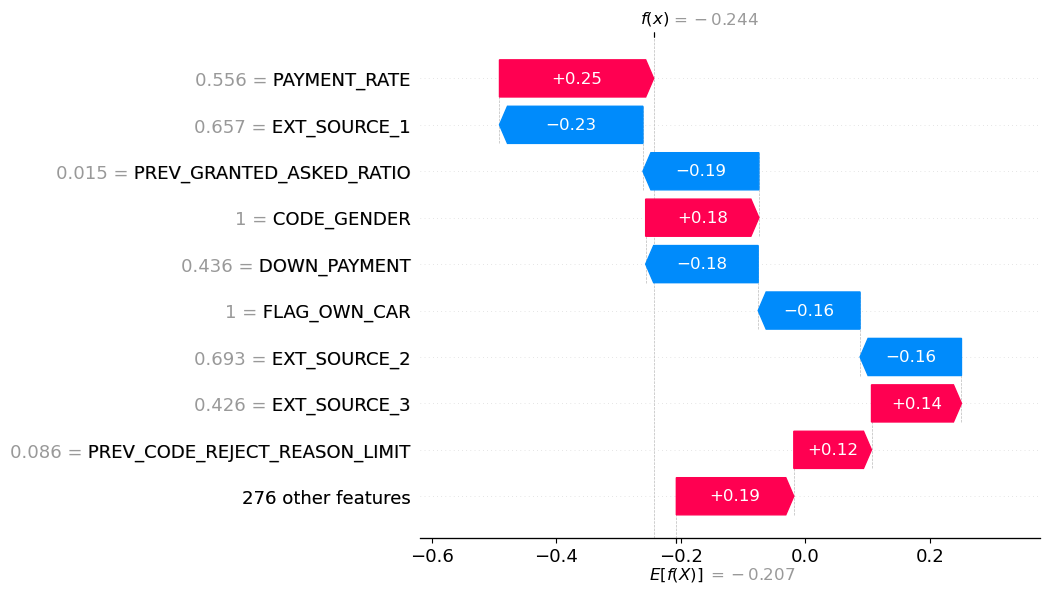

In [32]:
# Graphique d'explication individuelle détaillé
shap.waterfall_plot(shap.Explanation(values=shap_values[1][indice], 
                                     base_values=explainer.expected_value[1], 
                                     data=X_val_scaled[indice],
                                     feature_names=feature_names))

#### Test sur un autre individu

In [33]:
# Graphique de force pour une prédiction individuelle
indice = 1050

In [34]:
# Force plot pour cet individu :
shap.force_plot(explainer.expected_value[1], shap_values[1][indice], X_val_scaled[indice].reshape(1, -1).round(2), feature_names=feature_names)

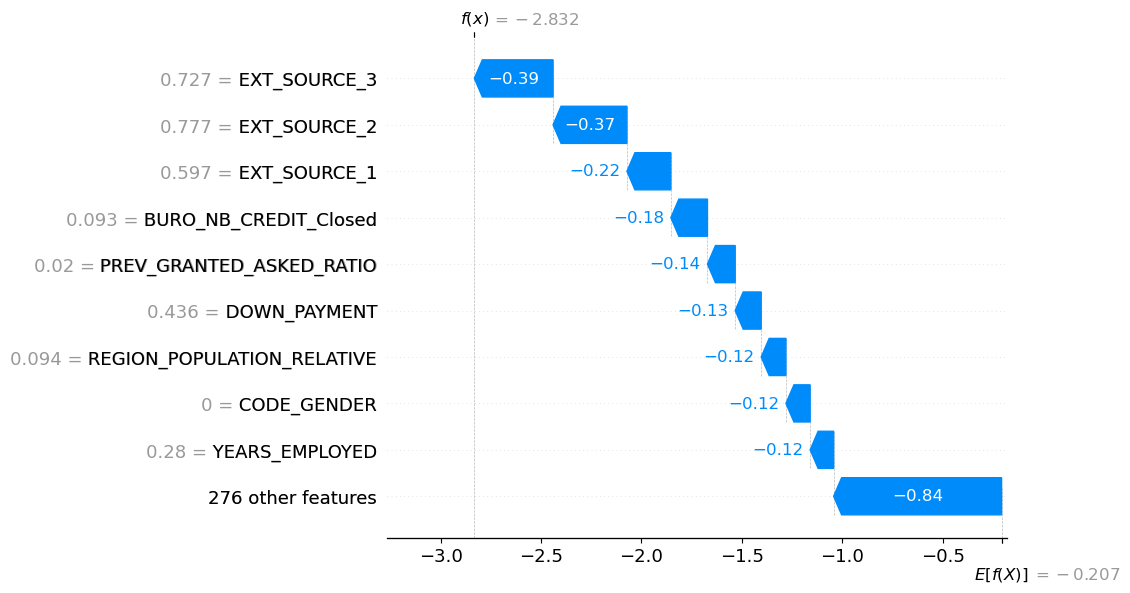

In [35]:
# Graphique d'explication individuelle détaillé
shap.waterfall_plot(shap.Explanation(values=shap_values[1][indice], 
                                     base_values=explainer.expected_value[1], 
                                     data=X_val_scaled[indice],
                                     feature_names=feature_names))

In [25]:
"""# Création de sous échantillons de données train et test : 

path = "F:/Utilisateur/Documents/Openclassrooms/Data Scientist/Formation/Projet 7 - Implémentez un modèle de scoring/Code_new/"
train_path = "training.csv"
test_path = "test.csv"

train_df = pd.read_csv(path + train_path)
train_df_samp = train_df.sample(1000, random_state = 42)

test_df = pd.read_csv(path + test_path)
test_df_samp = test_df.sample(1000, random_state = 42)

train_df_samp.to_csv("subset_train.csv", index=False)
test_df_samp.to_csv("subset_test.csv", index=False)"""